# **Real Time Multimodal Human Emotion Recognition: A Deep Learning Approach**

In [ ]:
!pip install tf-keras-vis lime mtcnn transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.3 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=331832af1fcdceed83bcedb1dec4195159102e8a896c6789ccaf635b6f759d57
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, ConvLSTM2D, Attention, TimeDistributed, Concatenate, LSTM
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.feature import hog
from skimage import exposure
import kagglehub
import gc
from mtcnn import MTCNN
#from feat.detector import Detector
#from gaze_tracking import GazeTracking
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torch
from tf_keras_vis.utils.scores import BinaryScore

In [ ]:
!pip install librosa

In [ ]:
import librosa
import librosa.display

In [ ]:
def Map_To_Threat_Level(Emotion):
  High_Threat_Emotions = ['angry' , 'disgust' , 'fear']
  Low_Threat_Emotions = ['happy' , 'neutral' , 'sad' , 'surprise']
  if Emotion in High_Threat_Emotions:
    return 'High Threat'
  else:
    return 'Low Threat'

In [ ]:
def Preprocess_Face_Expression_Dataset(Imgs_Path , Img_Size=(128,128) , Sample_frac = 0.05):

  Emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
  Data = {
      'Image_Paths': [],
      'Emotions': [],
      'Split': [],
      'Is_Augmented': [],
      'Threat_Level': [],
      'Image_Name': []
  }

  Data_Agm = ImageDataGenerator(
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
  )

  All_Images = []

  Output_Dir = "Processed_Images"
  os.makedirs(Output_Dir, exist_ok=True)

  for Split in ['train', 'validation']:
      Split_Path = os.path.join(Imgs_Path, 'images', Split)
      if not os.path.exists(Split_Path):
          print(f"Directory '{Split_Path}' does not exist.")
          continue
      for Emotion in Emotions:
          Emotion_Path = os.path.join(Split_Path, Emotion)
          if not os.path.exists(Emotion_Path):
              print(f"Directory '{Emotion_Path}' does not exist.")
              continue
          for Image_Name in os.listdir(Emotion_Path):
              if not Image_Name.endswith(('.jpg', '.jpeg', '.png')):
                  continue
              Image_Path = os.path.join(Emotion_Path, Image_Name)
              All_Images.append({
                  'Image_Path': Image_Path,
                  'Emotion': Emotion,
                  'Split': Split,
                  'Image_Name': Image_Name
              })

  df_All = pd.DataFrame(All_Images)
  df_Sample = df_All.groupby(['Emotion', 'Split'], group_keys=False).apply(
      lambda x: x.sample(frac=Sample_frac, random_state=42)
  ).reset_index(drop=True)

  print(f"Sampled {len(df_Sample)} Images from {len(df_All)} Total Images.")

  df_Sample['Threat_Level'] = df_Sample['Emotion'].apply(Map_To_Threat_Level)

  for _, Row in df_Sample.iterrows():
      Image_Path = Row['Image_Path']
      Emotion = Row['Emotion']
      Split = Row['Split']
      Image_Name = Row['Image_Name']
      Threat_Level = Row['Threat_Level']

      Image = cv2.imread(Image_Path, cv2.IMREAD_GRAYSCALE)
      if Image is None:
          continue

      Image_Resized = cv2.resize(Image, Img_Size)

      output_path = os.path.join(Output_Dir, f"{Split}_{Emotion}_{Image_Name}")
      cv2.imwrite(output_path, Image_Resized)
      Data['Image_Paths'].append(output_path)
      Data['Emotions'].append(Emotion)
      Data['Split'].append(Split)
      Data['Is_Augmented'].append(False)
      Data['Threat_Level'].append(Threat_Level)
      Data['Image_Name'].append(Image_Name)

      Image_Reshaped = Image_Resized.reshape(1, Img_Size[0], Img_Size[1], 1)

      Augmented_Images = Data_Agm.flow(Image_Reshaped, batch_size=1)

      for i in range(3):

          Augmented_Image = next(Augmented_Images)[0].astype('uint8')
          Aug_Path = os.path.join(Output_Dir, f"{Split}_{Emotion}_Aug{i}_{Image_Name}")
          cv2.imwrite(Aug_Path , Augmented_Image)
          Data['Image_Paths'].append(Aug_Path)
          Data['Emotions'].append(Emotion)
          Data['Split'].append(Split)
          Data['Is_Augmented'].append(True)
          Data['Threat_Level'].append(Threat_Level)
          Data['Image_Name'].append(Image_Name)

  df = pd.DataFrame(Data)
  return df

In [ ]:
def Face_Expression_EDA(Dataset_Name):

    df = pd.read_csv(Dataset_Name)
    print(f"Total Images in {Dataset_Name} : {len(df)}")
    print(f"Total Images in Train : {len(df[df['Split'] == 'train'])}")
    print(f"Total Images in Validation : {len(df[df['Split'] == 'validation'])}")
    print()

    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='Emotions', hue='Split')
    plt.title('Distribution of Emotions Across Splits')
    plt.xlabel('Emotions')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
    print()

    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='Threat_Level', hue='Split')
    plt.title('Distribution of Threat Levels Across Splits')
    plt.xlabel('Threat Level')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
    print()

    Emotions = df['Emotions'].unique()
    print(f"Emotions in Dataset : {Emotions}")
    print()


    Num_Emotions = len(Emotions)
    Num_Cols = 4
    Num_Rows = (Num_Emotions + Num_Cols - 1) // Num_Cols


    for Idx, Emotion in enumerate(Emotions):

        Emotion_Images = df[df['Emotions'] == Emotion]['Image_Paths'].unique()

        if len(Emotion_Images) > 0:
            Img_Path = Emotion_Images[0]
            plt.figure()
            Img = cv2.imread(Img_Path, cv2.IMREAD_GRAYSCALE)
            plt.imshow(Img, cmap=plt.cm.gray)
            plt.title(Emotion)
            plt.axis('off')
            plt.show()

In [ ]:
def Hog_Features(Dataset , Num_Samples = 100 , Num_Visualize = 10):

  df = pd.read_csv(Dataset)

  Emotions = df['Emotions'].unique()
  print(f"Emotions in Dataset : {Emotions}")
  print()

  Sample_per_Emotion = max(1 , Num_Samples // len(Emotions))
  print(f"Sample per Emotion : {Sample_per_Emotion}")

  df_Sample = df.groupby('Emotions' , group_keys=False).apply(
      lambda x: x.sample(n=min(Sample_per_Emotion , len(x))
      , random_state=42)).reset_index(drop=True)

  print(f"Total Samples in Dataset : {len(df_Sample)}")
  print()

  if len(df_Sample) < Num_Samples:
    Remaining = Num_Samples - len(df_Sample)
    Additional = df.drop(df_Sample.index).sample(n=Remaining , random_state=42)
    df_Sample = pd.concat([df_Sample , Additional] , ignore_index=True)


  df_Sample = df_Sample.sample(frac=1 , random_state=42).reset_index(drop=True)
  print(f"Total Samples in Sampled Dataset : {len(df_Sample)}")
  print()

  Hog_Features_Data = []
  Hog_Images = []

  for Img_Path in df_Sample['Image_Paths']:
    Img = cv2.imread(Img_Path, cv2.IMREAD_GRAYSCALE)
    Hog_Features, Hog_Img = hog(
        Img,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=True,
        block_norm='L2-Hys'
    )

    Hog_Features_Data.append(Hog_Features)
    Hog_Images.append(Hog_Img)


  Visualize_Indices = df_Sample.sample(n=Num_Visualize , random_state=42).index
  print(f"Visualize Indices : {Visualize_Indices}")
  print()

  fig , axes = plt.subplots(nrows= 5 , ncols= 4 , figsize=(15 , 20) ,
                           sharex=False , sharey=False)
  axes = axes.flatten()


  for Idx , Sample_Idx in enumerate(Visualize_Indices):
    Img_Path = df_Sample.loc[Sample_Idx , 'Image_Paths']
    Emotion = df_Sample.loc[Sample_Idx , 'Emotions']
    Img = cv2.imread(Img_Path , cv2.IMREAD_GRAYSCALE)

    ax1 = axes[Idx * 2]
    ax1.axis('off')
    ax1.imshow(Img , cmap=plt.cm.gray)
    ax1.set_title(f'Original Image : {Emotion}')

    ax2 = axes[Idx * 2 + 1]
    Hog_Image_Rescaled = exposure.rescale_intensity(Hog_Images[Sample_Idx] , in_range=(0 , 10))
    ax2.axis('off')
    ax2.imshow(Hog_Image_Rescaled , cmap=plt.cm.gray)
    ax2.set_title('Hog Visualization')


  plt.show()

  df_Sample['Hog_Features'] = Hog_Features_Data
  df_Sample.to_csv('Images_Dataset_Hog.csv' , index=False)

  return df_Sample

In [ ]:
def Preprocess_RAVDESS_Dataset(DATA_DIR, Output_DIR, Sample_Frac=1.0, Sr=16000, N_MFCC=13, Max_Length=200, Normalize=True):

    Feature_DIR = os.path.join(Output_DIR, 'Features')
    os.makedirs(Feature_DIR, exist_ok=True)

    print("Preprocessing RAVDESS Audio Dataset:")

    processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
    wav2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

    Data = {
        'Audio_Paths': [],
        'Feature_Paths': [],
        'Wav2Vec_Paths': [],
        'Labels': [],
        'Actor': [],
        'Gender': [],
        'Audio_Name': []
    }

    Labels = {
        '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
        '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
    }

    Audio_Files = []
    for root, _, files in os.walk(DATA_DIR):
        Audio_Files.extend(os.path.join(root, f) for f in files if f.endswith('.wav'))

    print(f"Found {len(Audio_Files)} audio files in {DATA_DIR}")
    print("\n")

    if not Audio_Files:
        print("No audio files found in the dataset.")
        return pd.DataFrame(Data)

    File_Records = []

    for Audio_Path in Audio_Files:
        Audio_Name = os.path.splitext(os.path.basename(Audio_Path))[0]
        Emotion_Code = Audio_Name.split('-')[2]
        Label = Labels.get(Emotion_Code, 'Unknown')
        Actor = Audio_Name.split('-')[6]
        Gender = 'Male' if int(Actor) % 2 == 1 else 'Female'
        File_Records.append({
            'Audio_Path': Audio_Path,
            'Audio_Name': Audio_Name,
            'Emotion_Code': Emotion_Code,
            'Label': Label,
            'Actor': Actor,
            'Gender': Gender
        })

    df_All = pd.DataFrame(File_Records)
    Actors = df_All['Actor'].unique()
    print(f"Found {len(Actors)} actors in the dataset.")
    print("\n")

    Total_Samples = max(len(Actors), int(len(Audio_Files) * Sample_Frac))
    Sampled_Actors = Actors
    print(f"Processing files from {len(Sampled_Actors)} actors.")
    print("\n")

    Sampled_Files = []

    for Actor in Sampled_Actors:
        Actor_Files = df_All[df_All['Actor'] == Actor]
        Num_Files = len(Actor_Files)
        Num_Samples = max(1, int(Num_Files * Sample_Frac))
        Sampled = Actor_Files.sample(n=Num_Samples, random_state=42)
        Sampled_Files.append(Sampled)

    df_sampled = pd.concat(Sampled_Files).reset_index(drop=True)
    print(f"Sampled {len(df_sampled)} audio files across {len(Sampled_Actors)} actors.")
    print("\n")

    for _, Row in tqdm(df_sampled.iterrows(), total=len(df_sampled), desc="Processing Audio Files"):
        Audio_Path = Row['Audio_Path']
        Audio_Name = Row['Audio_Name']
        Label = Row['Label']
        Actor = Row['Actor']
        Gender = Row['Gender']

        if Label == 'Unknown':
            print(f"Could not infer label for {Audio_Path}, skipping.")
            continue

        print(f"Processing audio: {Audio_Path}, Label: {Label}")

        Y, _ = librosa.load(Audio_Path, sr=Sr)
        Y, _ = librosa.effects.trim(Y)

        if Normalize:
            Y = Y / np.max(np.abs(Y))

        MFCCS = librosa.feature.mfcc(y=Y, sr=Sr, n_mfcc=N_MFCC)

        if MFCCS.shape[1] < Max_Length:
            MFCCS = np.pad(MFCCS, ((0, 0), (0, Max_Length - MFCCS.shape[1])), mode='constant')
        else:
            MFCCS = MFCCS[:, :Max_Length]

        if MFCCS is None:
            print(f"Failed to extract MFCCs from {Audio_Path}, skipping.")
            continue

        inputs = processor(Y, sampling_rate=Sr, return_tensors="pt", padding=True)
        with torch.no_grad():
            Wav2Vec_Features = wav2vec_model(inputs.input_values).last_hidden_state.squeeze().numpy()

        Feature_Path = os.path.join(Feature_DIR, f"{Audio_Name}_mfcc.npy")
        Wav2Vec_Path = os.path.join(Feature_DIR, f"{Audio_Name}_wav2vec.npy")
        np.save(Feature_Path, MFCCS)
        np.save(Wav2Vec_Path, Wav2Vec_Features)
        print(f"Saved features: {Feature_Path}")
        print(f"Saved Wav2Vec features: {Wav2Vec_Path}")

        Data['Audio_Paths'].append(Audio_Path)
        Data['Feature_Paths'].append(Feature_Path)
        Data['Wav2Vec_Paths'].append(Wav2Vec_Path)
        Data['Labels'].append(Label)
        Data['Actor'].append(Actor)
        Data['Gender'].append(Gender)
        Data['Audio_Name'].append(Audio_Name)

    df = pd.DataFrame(Data)
    print(f"Processed {len(df)} audio files.")
    print(f"Label distribution:\n{df['Labels'].value_counts()}")
    print(f"Gender distribution:\n{df['Gender'].value_counts()}")
    print("\n")

    Output_Data_Path = os.path.join(Output_DIR, 'RAVDESS_Dataset.csv')
    df.to_csv(Output_Data_Path, index=False)
    print(f"Metadata saved to {Output_Data_Path}")
    print("\n")

    return df



In [ ]:
def EDA_RAVDESS_Dataset(Dataset_Path, Num_Visualizations=5):

    df = pd.read_csv(Dataset_Path)

    print("Label Distribution:")
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x='Labels', hue='Labels')
    plt.title('Label Distribution')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
    print("\n")

    print("\nGender Distribution:")
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x='Gender', hue='Gender')
    plt.title('Gender Distribution')
    plt.xlabel('Gender')
    plt.ylabel('Count')
    plt.show()
    print("\n")

    print("\nActor Distribution:")
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x='Actor', hue='Actor')
    plt.title('Actor Distribution')
    plt.xlabel('Actor')
    plt.ylabel('Count')
    plt.show()
    print("\n")

    print("\nAudio Length Distribution:")
    df['Audio_Length'] = df['Audio_Paths'].apply(lambda x: librosa.get_duration(filename=x))
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df, x='Audio_Length', bins=30, kde=True)
    plt.title('Audio Length Distribution')
    plt.xlabel('Audio Length (seconds)')
    plt.ylabel('Count')
    plt.show()
    print("\n")

    print("\nLabel vs Gender Cross-Tabulation:")
    cross_tab_gender = pd.crosstab(df['Labels'], df['Gender'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cross_tab_gender, annot=True, fmt='d', cmap='Blues')
    plt.title('Labels vs Gender')
    plt.xlabel('Gender')
    plt.ylabel('Labels')
    plt.show()
    print("\n")

    print("\n Visualizing Sample Audio Spectrograms : ")
    Sample_Audios = df.sample(n=Num_Visualizations, random_state=42)

    for Idx, Audio_Path in enumerate(Sample_Audios['Audio_Paths']):
      Y, _ = librosa.load(Audio_Path , sr =22050)
      S = librosa.feature.melspectrogram(y=Y, sr=22050)
      plt.figure(figsize=(8, 6))
      librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='log', x_axis='time')
      plt.title(f'Sample Audio Spectrogram {Idx + 1}')
      plt.colorbar(format='%+2.0f dB')
      plt.show()
      print("\n")

    print("\n")

    print("\nVisualizing Sample Audio Waveforms : ")
    Sample_Audios = df.sample(n=Num_Visualizations, random_state=42)
    for Idx, Audio_Path in enumerate(Sample_Audios['Audio_Paths']):
        Y, _ = librosa.load(Audio_Path , sr = 22050)
        plt.figure(figsize=(8, 6))
        librosa.display.waveshow(Y, sr=22050)
        plt.title(f'Sample Audio Waveform {Idx + 1}')
        plt.show()
        print("\n")

    print("\n")

    print("\nMFCC Visualization : ")
    Sample_Features = df.sample(n=Num_Visualizations, random_state=42)
    for Idx, Feature_Path in enumerate(Sample_Features['Feature_Paths']):
        MFCCs = np.load(Feature_Path)
        plt.figure(figsize=(8, 6))
        librosa.display.specshow(MFCCs, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Sample MFCCs {Idx + 1}')
        plt.show()
        print("\n")

    print("\n")

In [ ]:
def RAVDESS_Feature_Engeenring(Dataset , Output_Dir):

    df = pd.read_csv(Dataset)

    Spectral_Centroid_Data = []
    Spectral_Rolloff_Data = []
    Spectral_Flatness_Data = []
    ZCR_Data = []

    for Audio_Path in tqdm(df['Audio_Paths'] , desc="Processing Audio Files"):

        Y, _ = librosa.load(Audio_Path, sr=22050)

        # Spectral Centroid
        Centroid = librosa.feature.spectral_centroid(y=Y, sr=22050)
        Centroid_Mean = np.mean(Centroid)
        Spectral_Centroid_Data.append(Centroid_Mean)

        # Spectral Rolloff
        Rolloff = librosa.feature.spectral_rolloff(y=Y, sr=22050)
        Rolloff_Mean = np.mean(Rolloff)
        Spectral_Rolloff_Data.append(Rolloff_Mean)

        # Spectral Flatness
        Flatness = librosa.feature.spectral_flatness(y=Y)
        Flatness_Mean = np.mean(Flatness)
        Spectral_Flatness_Data.append(Flatness_Mean)

        # Zero Crossing Rate
        ZCR = librosa.feature.zero_crossing_rate(y=Y)
        ZCR_Mean = np.mean(ZCR)
        ZCR_Data.append(ZCR_Mean)

    df['Spectral_Centroid'] = Spectral_Centroid_Data
    df['Spectral_Rolloff'] = Spectral_Rolloff_Data
    df['Spectral_Flatness'] = Spectral_Flatness_Data
    df['ZCR'] = ZCR_Data

    df.to_csv(os.path.join(Output_Dir , 'RAVDESS_Dataset_Features.csv') , index=False)
    print(f"Features saved to {os.path.join(Output_Dir , 'RAVDESS_Dataset_Features.csv')}")

    return df

In [ ]:
def Plot_Features(Dataset):
    df = pd.read_csv(Dataset)

    Features = ['Spectral_Centroid' , 'Spectral_Rolloff' , 'Spectral_Flatness' , 'ZCR']
    for Feature in Features:
        plt.figure(figsize=(8, 6))
        sns.histplot(data=df, x=Feature, bins=30, kde=True)
        plt.title(f'{Feature} Distribution')
        plt.xlabel(Feature)
        plt.ylabel('Count')
        plt.show()
        print("\n")

        print(f"\n{Feature} by Emotion:")
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df, x='Labels', y=Feature)
        plt.title(f'{Feature} by Emotion')
        plt.xlabel('Emotion')
        plt.ylabel(Feature)
        plt.xticks(rotation=45)
        plt.show()
        print("\n")

        print(f"\n{Feature} by Gender:")
        plt.figure(figsize=(8, 6))
        sns.boxplot(data=df, x='Gender', y=Feature)
        plt.title(f'{Feature} by Gender')
        plt.xlabel('Gender')
        plt.ylabel(Feature)
        plt.show()
        print("\n")


    print("\nCorrelation Heatmap of Features : ")
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[Features].corr(), annot=True, cmap='coolwarm', fmt=".2f" , vmax=1 , vmin=-1)
    plt.title('Correlation Heatmap of Features')
    plt.show()
    print("\n")

In [ ]:
def Visualize_Features(Dataset , Num_Visualizations = 2):

  df = pd.read_csv(Dataset)

  Features = ['Spectral_Centroid' , 'Spectral_Rolloff' , 'Spectral_Flatness' , 'ZCR']

  Sample_Features = df.sample(n=Num_Visualizations , random_state=42)

  for Idx , Feature in enumerate(Features):
    print(f"Feature : {Feature}")

    Audio_Path = Sample_Features['Audio_Paths'].iloc[Idx % len(Sample_Features)]
    Y , _ = librosa.load(Audio_Path , sr=22050)
    Times = librosa.times_like(Y , sr=22050)

    plt.figure(figsize=(10, 6))
    plt.plot(Times , Y , color='blue')
    plt.title(f'Time Series Plot of {Feature}')
    plt.xlabel('Time')
    plt.ylabel(Feature)
    plt.show()
    print("\n")

  print("\n")

In [ ]:
Imgs_Path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")
print("Path to dataset files:", Imgs_Path)

print(f"Directory Contents : {os.listdir(Imgs_Path)}")

print(f"Subdirectories in Images Contents : {os.listdir(os.path.join(Imgs_Path, 'images'))}")

Images_Dataset = Preprocess_Face_Expression_Dataset(Imgs_Path)
Images_Dataset.to_csv('Images_Dataset.csv' , index=False)

Path to dataset files: /kaggle/input/face-expression-recognition-dataset
Directory Contents : ['images']
Subdirectories in Images Contents : ['validation', 'images', 'train']


<ipython-input-6-483bdfb1b826>:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_Sample = df_All.groupby(['Emotion', 'Split'], group_keys=False).apply(


Sampled 1795 Images from 35887 Total Images.


Total Images in Images_Dataset.csv : 7180
Total Images in Train : 5764
Total Images in Validation : 1416



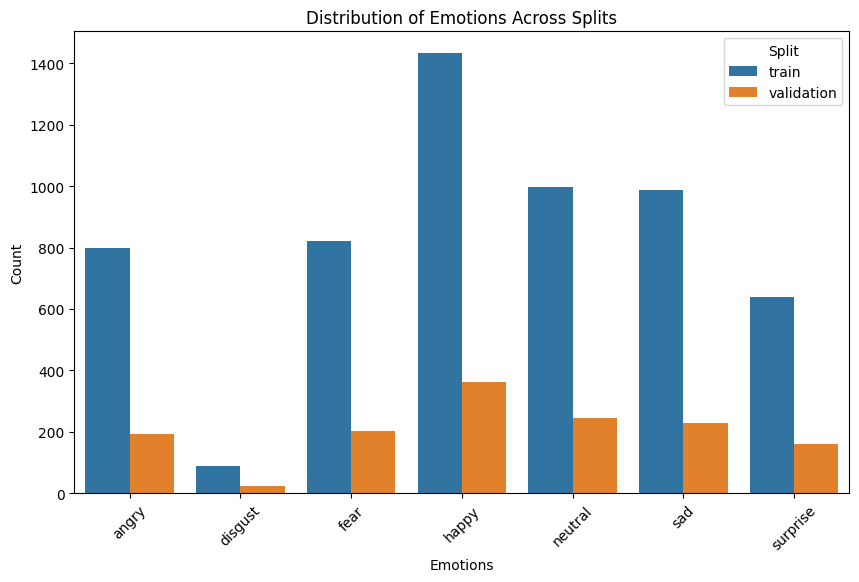

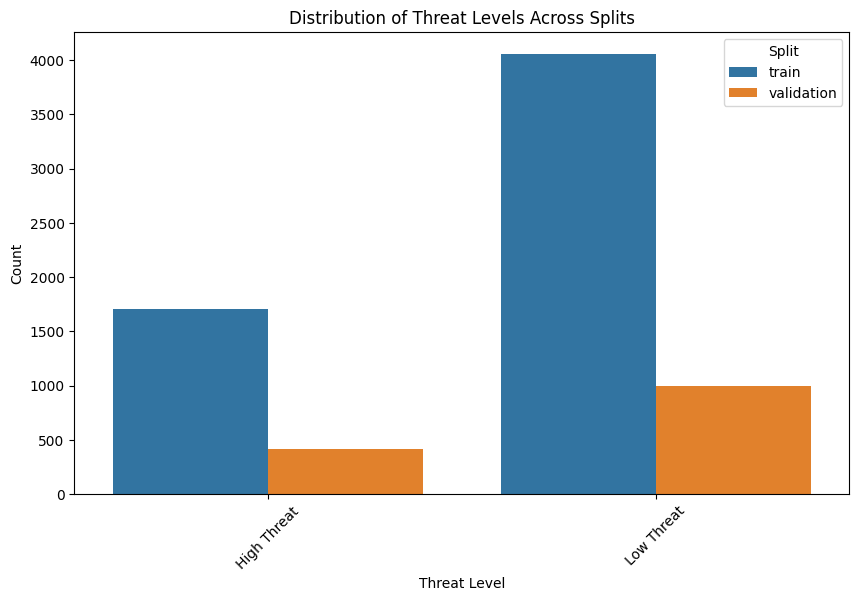


Emotions in Dataset : ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']



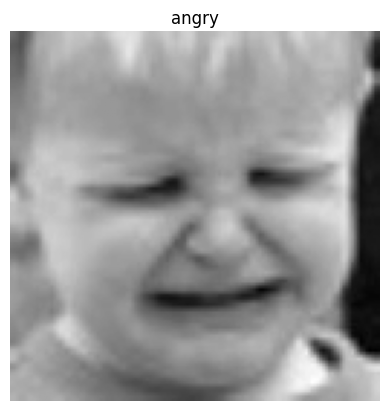

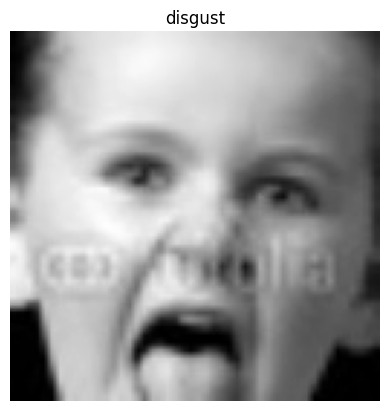

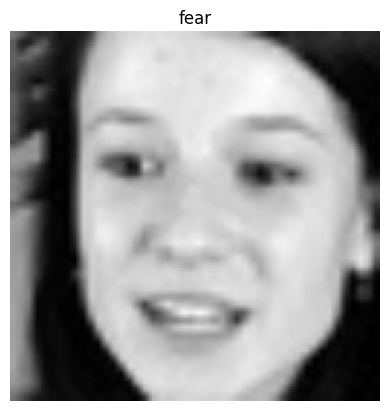

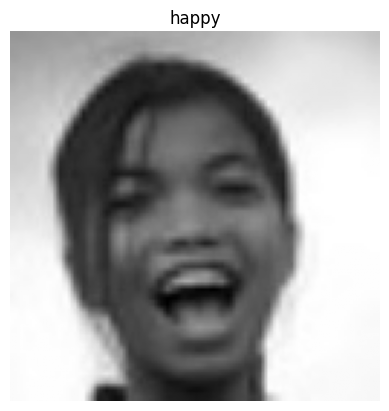

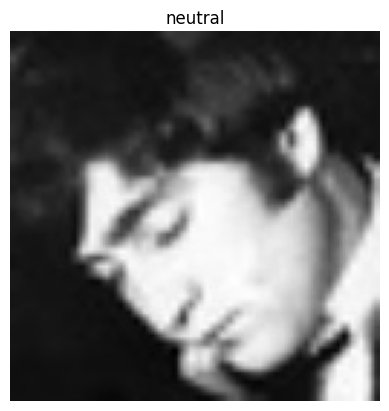

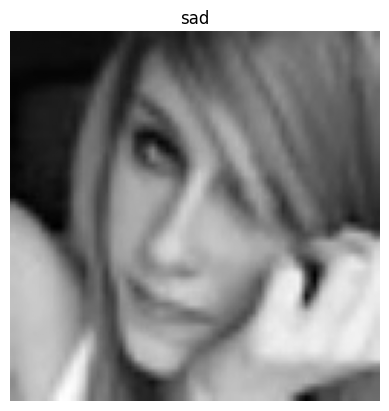

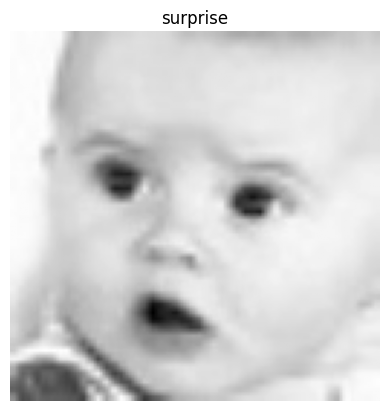

In [ ]:
Image_Dataset = 'Images_Dataset.csv'
Face_Expression_EDA(Image_Dataset)

Emotions in Dataset : ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']

Sample per Emotion : 14
Total Samples in Dataset : 98

Total Samples in Sampled Dataset : 100



<ipython-input-8-24a11b0b5f0d>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_Sample = df.groupby('Emotions' , group_keys=False).apply(


Visualize Indices : Index([83, 53, 70, 45, 44, 39, 22, 80, 10, 0], dtype='int64')



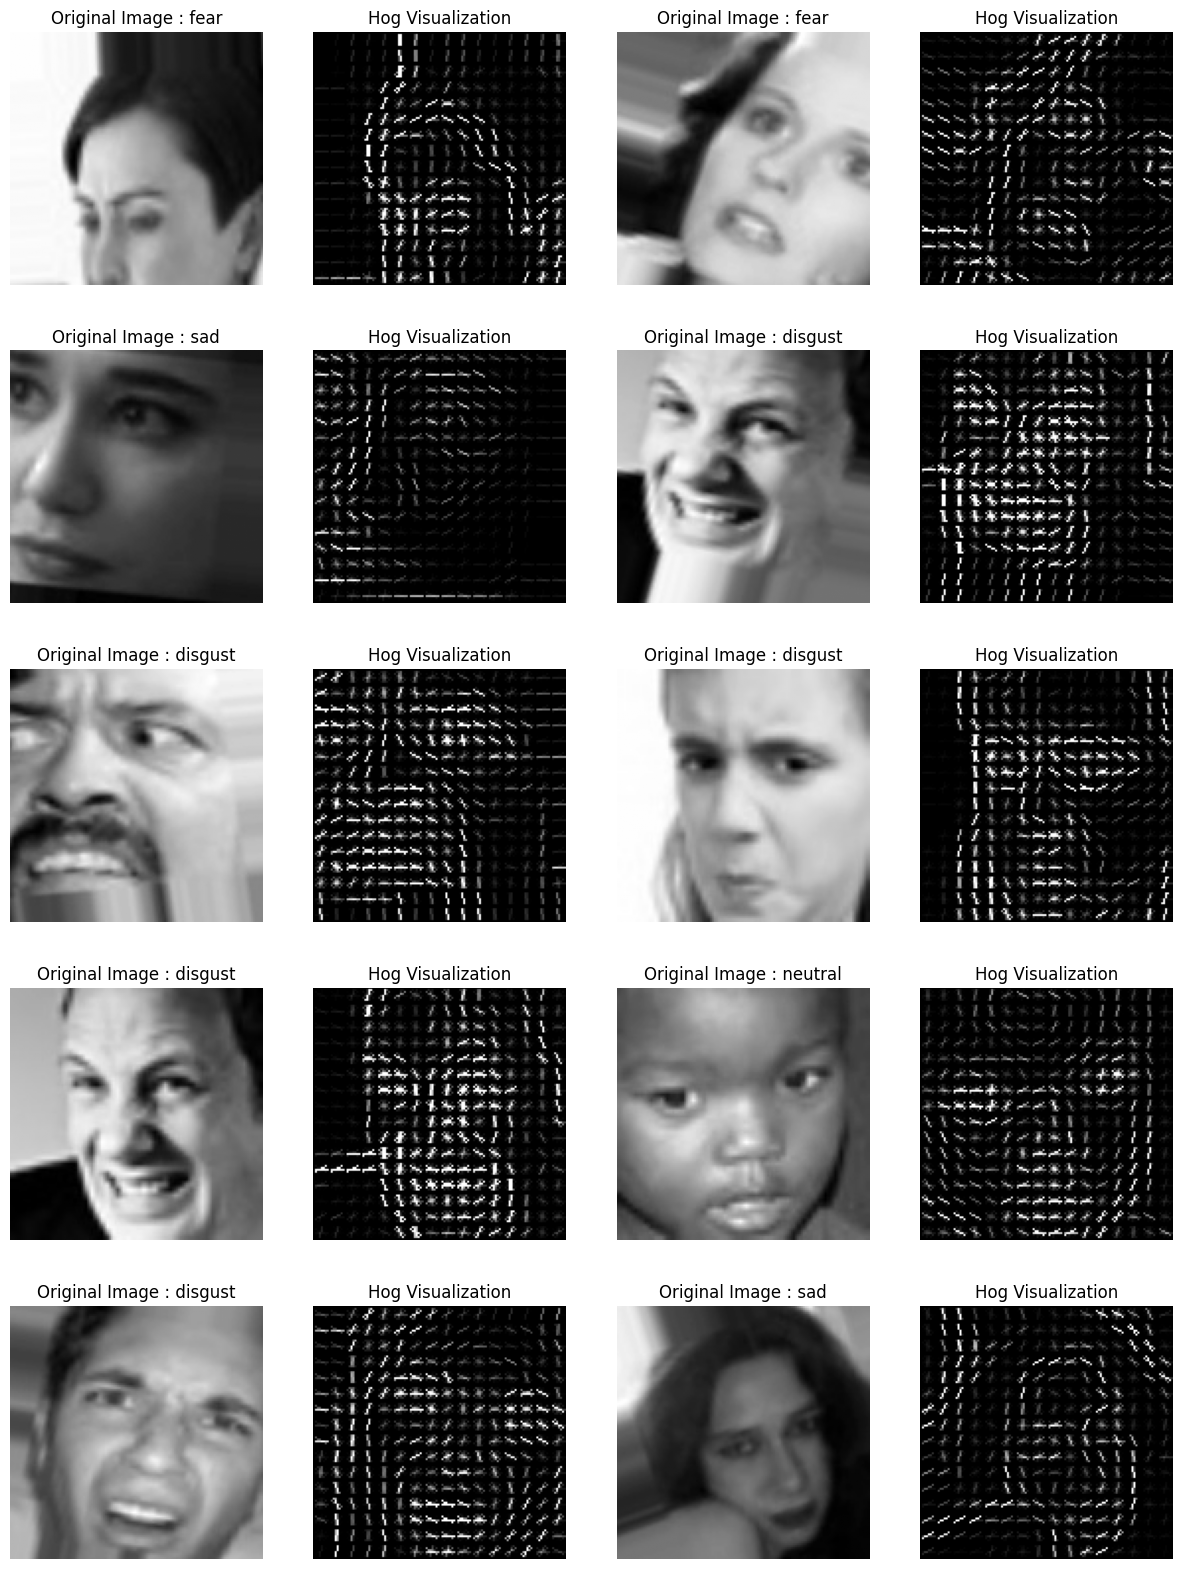

In [ ]:
Feature_Face_Expresion = Hog_Features('Images_Dataset.csv')

In [ ]:
Audio_Path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
print("Path to dataset files:", Audio_Path)

Path to dataset files: /kaggle/input/ravdess-emotional-speech-audio


In [ ]:
Audio_Dataset = Preprocess_RAVDESS_Dataset(Audio_Path, Output_DIR='Processed_Ravdess' , Sample_Frac=0.1)

Preprocessing RAVDESS Audio Dataset:


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Found 2880 audio files in /kaggle/input/ravdess-emotional-speech-audio


Found 24 actors in the dataset.


Processing files from 24 actors.


Sampled 288 audio files across 24 actors.




Processing Audio Files:   0%|          | 0/288 [00:00<?, ?it/s]

Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-02-01-01-01-02.wav, Label: calm


Processing Audio Files:   0%|          | 1/288 [00:14<1:08:28, 14.32s/it]

Saved features: Processed_Ravdess/Features/03-01-02-01-01-01-02_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-01-01-01-02_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-06-01-01-02-02.wav, Label: fearful


Processing Audio Files:   1%|          | 2/288 [00:15<30:33,  6.41s/it]  

Saved features: Processed_Ravdess/Features/03-01-06-01-01-02-02_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-01-01-02-02_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-02-01-02.wav, Label: neutral


Processing Audio Files:   1%|          | 3/288 [00:15<17:56,  3.78s/it]

Saved features: Processed_Ravdess/Features/03-01-01-01-02-01-02_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-01-01-02-01-02_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-02-02-01-01-02.wav, Label: calm


Processing Audio Files:   1%|▏         | 4/288 [00:16<12:16,  2.59s/it]

Saved features: Processed_Ravdess/Features/03-01-02-02-01-01-02_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-02-01-01-02_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-05-02-02-01-02.wav, Label: angry


Processing Audio Files:   2%|▏         | 5/288 [00:17<08:40,  1.84s/it]

Saved features: Processed_Ravdess/Features/03-01-05-02-02-01-02_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-02-02-01-02_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-01-01-02-01-02.wav, Label: neutral


Processing Audio Files:   2%|▏         | 6/288 [00:17<06:20,  1.35s/it]

Saved features: Processed_Ravdess/Features/03-01-01-01-02-01-02_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-01-01-02-01-02_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-06-02-01-02-02.wav, Label: fearful


Processing Audio Files:   2%|▏         | 7/288 [00:18<05:02,  1.08s/it]

Saved features: Processed_Ravdess/Features/03-01-06-02-01-02-02_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-02-01-02-02_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-07-01-02-02-02.wav, Label: disgust


Processing Audio Files:   3%|▎         | 8/288 [00:18<04:05,  1.14it/s]

Saved features: Processed_Ravdess/Features/03-01-07-01-02-02-02_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-01-02-02-02_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-06-01-02-01-02.wav, Label: fearful


Processing Audio Files:   3%|▎         | 9/288 [00:19<03:37,  1.28it/s]

Saved features: Processed_Ravdess/Features/03-01-06-01-02-01-02_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-01-02-01-02_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-06-01-01-02-02.wav, Label: fearful


Processing Audio Files:   3%|▎         | 10/288 [00:19<03:16,  1.42it/s]

Saved features: Processed_Ravdess/Features/03-01-06-01-01-02-02_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-01-01-02-02_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-04-02-02-02-02.wav, Label: sad


Processing Audio Files:   4%|▍         | 11/288 [00:20<02:57,  1.56it/s]

Saved features: Processed_Ravdess/Features/03-01-04-02-02-02-02_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-04-02-02-02-02_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-07-02-01-02-02.wav, Label: disgust


Processing Audio Files:   4%|▍         | 12/288 [00:20<02:44,  1.68it/s]

Saved features: Processed_Ravdess/Features/03-01-07-02-01-02-02_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-02-01-02-02_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_17/03-01-04-01-02-02-17.wav, Label: sad


Processing Audio Files:   5%|▍         | 13/288 [00:21<02:51,  1.60it/s]

Saved features: Processed_Ravdess/Features/03-01-04-01-02-02-17_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-04-01-02-02-17_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_17/03-01-05-01-01-01-17.wav, Label: angry


Processing Audio Files:   5%|▍         | 14/288 [00:21<02:51,  1.60it/s]

Saved features: Processed_Ravdess/Features/03-01-05-01-01-01-17_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-01-01-01-17_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_17/03-01-07-01-02-01-17.wav, Label: disgust


Processing Audio Files:   5%|▌         | 15/288 [00:22<02:55,  1.56it/s]

Saved features: Processed_Ravdess/Features/03-01-07-01-02-01-17_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-01-02-01-17_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_17/03-01-08-02-02-01-17.wav, Label: surprised


Processing Audio Files:   6%|▌         | 16/288 [00:23<02:50,  1.60it/s]

Saved features: Processed_Ravdess/Features/03-01-08-02-02-01-17_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-02-02-01-17_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_17/03-01-03-02-02-02-17.wav, Label: happy


Processing Audio Files:   6%|▌         | 17/288 [00:23<02:55,  1.55it/s]

Saved features: Processed_Ravdess/Features/03-01-03-02-02-02-17_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-03-02-02-02-17_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_17/03-01-07-01-02-01-17.wav, Label: disgust


Processing Audio Files:   6%|▋         | 18/288 [00:24<02:55,  1.53it/s]

Saved features: Processed_Ravdess/Features/03-01-07-01-02-01-17_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-01-02-01-17_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_17/03-01-08-02-01-01-17.wav, Label: surprised


Processing Audio Files:   7%|▋         | 19/288 [00:25<02:53,  1.55it/s]

Saved features: Processed_Ravdess/Features/03-01-08-02-01-01-17_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-02-01-01-17_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_17/03-01-07-01-01-02-17.wav, Label: disgust


Processing Audio Files:   7%|▋         | 20/288 [00:25<02:57,  1.51it/s]

Saved features: Processed_Ravdess/Features/03-01-07-01-01-02-17_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-01-01-02-17_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_17/03-01-06-01-02-02-17.wav, Label: fearful


Processing Audio Files:   7%|▋         | 21/288 [00:26<02:55,  1.52it/s]

Saved features: Processed_Ravdess/Features/03-01-06-01-02-02-17_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-01-02-02-17_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_17/03-01-05-01-01-01-17.wav, Label: angry


Processing Audio Files:   8%|▊         | 22/288 [00:27<03:10,  1.39it/s]

Saved features: Processed_Ravdess/Features/03-01-05-01-01-01-17_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-01-01-01-17_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_17/03-01-08-01-02-02-17.wav, Label: surprised


Processing Audio Files:   8%|▊         | 23/288 [00:28<03:25,  1.29it/s]

Saved features: Processed_Ravdess/Features/03-01-08-01-02-02-17_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-01-02-02-17_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_17/03-01-03-01-01-02-17.wav, Label: happy


Processing Audio Files:   8%|▊         | 24/288 [00:29<03:39,  1.20it/s]

Saved features: Processed_Ravdess/Features/03-01-03-01-01-02-17_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-03-01-01-02-17_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_05/03-01-03-01-01-02-05.wav, Label: happy


Processing Audio Files:   9%|▊         | 25/288 [00:29<03:25,  1.28it/s]

Saved features: Processed_Ravdess/Features/03-01-03-01-01-02-05_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-03-01-01-02-05_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_05/03-01-02-01-02-01-05.wav, Label: calm


Processing Audio Files:   9%|▉         | 26/288 [00:30<03:25,  1.27it/s]

Saved features: Processed_Ravdess/Features/03-01-02-01-02-01-05_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-01-02-01-05_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_05/03-01-02-02-02-01-05.wav, Label: calm


Processing Audio Files:   9%|▉         | 27/288 [00:31<03:28,  1.25it/s]

Saved features: Processed_Ravdess/Features/03-01-02-02-02-01-05_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-02-02-01-05_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_05/03-01-02-01-01-02-05.wav, Label: calm


Processing Audio Files:  10%|▉         | 28/288 [00:32<03:23,  1.28it/s]

Saved features: Processed_Ravdess/Features/03-01-02-01-01-02-05_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-01-01-02-05_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_05/03-01-01-01-01-01-05.wav, Label: neutral


Processing Audio Files:  10%|█         | 29/288 [00:32<03:11,  1.35it/s]

Saved features: Processed_Ravdess/Features/03-01-01-01-01-01-05_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-01-01-01-01-05_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_05/03-01-02-02-02-01-05.wav, Label: calm


Processing Audio Files:  10%|█         | 30/288 [00:34<03:57,  1.09it/s]

Saved features: Processed_Ravdess/Features/03-01-02-02-02-01-05_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-02-02-01-05_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_05/03-01-03-01-02-01-05.wav, Label: happy


Processing Audio Files:  11%|█         | 31/288 [00:35<04:04,  1.05it/s]

Saved features: Processed_Ravdess/Features/03-01-03-01-02-01-05_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-03-01-02-01-05_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_05/03-01-05-01-01-02-05.wav, Label: angry


Processing Audio Files:  11%|█         | 32/288 [00:35<03:38,  1.17it/s]

Saved features: Processed_Ravdess/Features/03-01-05-01-01-02-05_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-01-01-02-05_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_05/03-01-07-01-01-02-05.wav, Label: disgust


Processing Audio Files:  11%|█▏        | 33/288 [00:36<03:27,  1.23it/s]

Saved features: Processed_Ravdess/Features/03-01-07-01-01-02-05_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-01-01-02-05_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_05/03-01-02-01-02-01-05.wav, Label: calm


Processing Audio Files:  12%|█▏        | 34/288 [00:37<03:22,  1.26it/s]

Saved features: Processed_Ravdess/Features/03-01-02-01-02-01-05_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-01-02-01-05_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_05/03-01-04-02-01-02-05.wav, Label: sad


Processing Audio Files:  12%|█▏        | 35/288 [00:37<03:07,  1.35it/s]

Saved features: Processed_Ravdess/Features/03-01-04-02-01-02-05_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-04-02-01-02-05_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_05/03-01-07-02-02-01-05.wav, Label: disgust


Processing Audio Files:  12%|█▎        | 36/288 [00:38<03:09,  1.33it/s]

Saved features: Processed_Ravdess/Features/03-01-07-02-02-01-05_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-02-02-01-05_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_16/03-01-04-02-01-01-16.wav, Label: sad


Processing Audio Files:  13%|█▎        | 37/288 [00:39<02:55,  1.43it/s]

Saved features: Processed_Ravdess/Features/03-01-04-02-01-01-16_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-04-02-01-01-16_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_16/03-01-06-01-02-01-16.wav, Label: fearful


Processing Audio Files:  13%|█▎        | 38/288 [00:40<03:07,  1.33it/s]

Saved features: Processed_Ravdess/Features/03-01-06-01-02-01-16_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-01-02-01-16_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_16/03-01-05-02-01-02-16.wav, Label: angry


Processing Audio Files:  14%|█▎        | 39/288 [00:40<02:56,  1.41it/s]

Saved features: Processed_Ravdess/Features/03-01-05-02-01-02-16_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-02-01-02-16_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_16/03-01-05-02-02-01-16.wav, Label: angry


Processing Audio Files:  14%|█▍        | 40/288 [00:41<02:50,  1.46it/s]

Saved features: Processed_Ravdess/Features/03-01-05-02-02-01-16_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-02-02-01-16_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_16/03-01-03-02-01-01-16.wav, Label: happy


Processing Audio Files:  14%|█▍        | 41/288 [00:42<02:48,  1.47it/s]

Saved features: Processed_Ravdess/Features/03-01-03-02-01-01-16_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-03-02-01-01-16_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_16/03-01-05-02-01-02-16.wav, Label: angry


Processing Audio Files:  15%|█▍        | 42/288 [00:42<02:40,  1.53it/s]

Saved features: Processed_Ravdess/Features/03-01-05-02-01-02-16_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-02-01-02-16_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_16/03-01-08-02-02-01-16.wav, Label: surprised


Processing Audio Files:  15%|█▍        | 43/288 [00:43<02:27,  1.67it/s]

Saved features: Processed_Ravdess/Features/03-01-08-02-02-01-16_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-02-02-01-16_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_16/03-01-03-01-02-02-16.wav, Label: happy


Processing Audio Files:  15%|█▌        | 44/288 [00:43<02:21,  1.73it/s]

Saved features: Processed_Ravdess/Features/03-01-03-01-02-02-16_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-03-01-02-02-16_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_16/03-01-06-02-02-02-16.wav, Label: fearful


Processing Audio Files:  16%|█▌        | 45/288 [00:44<02:15,  1.79it/s]

Saved features: Processed_Ravdess/Features/03-01-06-02-02-02-16_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-02-02-02-16_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_16/03-01-06-01-02-01-16.wav, Label: fearful


Processing Audio Files:  16%|█▌        | 46/288 [00:44<02:19,  1.73it/s]

Saved features: Processed_Ravdess/Features/03-01-06-01-02-01-16_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-01-02-01-16_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_16/03-01-06-02-02-01-16.wav, Label: fearful


Processing Audio Files:  16%|█▋        | 47/288 [00:45<02:15,  1.78it/s]

Saved features: Processed_Ravdess/Features/03-01-06-02-02-01-16_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-02-02-01-16_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_16/03-01-04-02-01-02-16.wav, Label: sad


Processing Audio Files:  17%|█▋        | 48/288 [00:46<02:27,  1.62it/s]

Saved features: Processed_Ravdess/Features/03-01-04-02-01-02-16_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-04-02-01-02-16_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_21/03-01-05-01-01-02-21.wav, Label: angry


Processing Audio Files:  17%|█▋        | 49/288 [00:46<02:32,  1.57it/s]

Saved features: Processed_Ravdess/Features/03-01-05-01-01-02-21_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-01-01-02-21_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_21/03-01-03-01-01-01-21.wav, Label: happy


Processing Audio Files:  17%|█▋        | 50/288 [00:47<02:21,  1.69it/s]

Saved features: Processed_Ravdess/Features/03-01-03-01-01-01-21_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-03-01-01-01-21_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_21/03-01-08-01-01-01-21.wav, Label: surprised


Processing Audio Files:  18%|█▊        | 51/288 [00:47<02:13,  1.77it/s]

Saved features: Processed_Ravdess/Features/03-01-08-01-01-01-21_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-01-01-01-21_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_21/03-01-03-02-02-02-21.wav, Label: happy


Processing Audio Files:  18%|█▊        | 52/288 [00:48<02:06,  1.86it/s]

Saved features: Processed_Ravdess/Features/03-01-03-02-02-02-21_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-03-02-02-02-21_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_21/03-01-08-01-02-02-21.wav, Label: surprised


Processing Audio Files:  18%|█▊        | 53/288 [00:48<02:01,  1.93it/s]

Saved features: Processed_Ravdess/Features/03-01-08-01-02-02-21_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-01-02-02-21_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_21/03-01-08-01-01-01-21.wav, Label: surprised


Processing Audio Files:  19%|█▉        | 54/288 [00:49<01:58,  1.97it/s]

Saved features: Processed_Ravdess/Features/03-01-08-01-01-01-21_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-01-01-01-21_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_21/03-01-08-02-01-01-21.wav, Label: surprised


Processing Audio Files:  19%|█▉        | 55/288 [00:49<01:56,  1.99it/s]

Saved features: Processed_Ravdess/Features/03-01-08-02-01-01-21_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-02-01-01-21_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_21/03-01-07-01-01-01-21.wav, Label: disgust


Processing Audio Files:  19%|█▉        | 56/288 [00:50<01:55,  2.02it/s]

Saved features: Processed_Ravdess/Features/03-01-07-01-01-01-21_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-01-01-01-21_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_21/03-01-02-01-02-02-21.wav, Label: calm


Processing Audio Files:  20%|█▉        | 57/288 [00:50<02:10,  1.77it/s]

Saved features: Processed_Ravdess/Features/03-01-02-01-02-02-21_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-01-02-02-21_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_21/03-01-03-01-01-01-21.wav, Label: happy


Processing Audio Files:  20%|██        | 58/288 [00:51<02:05,  1.83it/s]

Saved features: Processed_Ravdess/Features/03-01-03-01-01-01-21_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-03-01-01-01-21_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_21/03-01-08-01-01-02-21.wav, Label: surprised


Processing Audio Files:  20%|██        | 59/288 [00:51<01:58,  1.93it/s]

Saved features: Processed_Ravdess/Features/03-01-08-01-01-02-21_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-01-01-02-21_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_21/03-01-01-01-01-01-21.wav, Label: neutral


Processing Audio Files:  21%|██        | 60/288 [00:52<01:57,  1.94it/s]

Saved features: Processed_Ravdess/Features/03-01-01-01-01-01-21_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-01-01-01-01-21_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-07-01-01-01-01.wav, Label: disgust


Processing Audio Files:  21%|██        | 61/288 [00:53<02:15,  1.68it/s]

Saved features: Processed_Ravdess/Features/03-01-07-01-01-01-01_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-01-01-01-01_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-08-02-02-01-01.wav, Label: surprised


Processing Audio Files:  22%|██▏       | 62/288 [00:53<02:10,  1.73it/s]

Saved features: Processed_Ravdess/Features/03-01-08-02-02-01-01_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-02-02-01-01_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-02-01-02-01-01.wav, Label: calm


Processing Audio Files:  22%|██▏       | 63/288 [00:54<02:15,  1.67it/s]

Saved features: Processed_Ravdess/Features/03-01-02-01-02-01-01_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-01-02-01-01_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-07-02-02-02-01.wav, Label: disgust


Processing Audio Files:  22%|██▏       | 64/288 [00:55<02:42,  1.38it/s]

Saved features: Processed_Ravdess/Features/03-01-07-02-02-02-01_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-02-02-02-01_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-06-01-01-01-01.wav, Label: fearful


Processing Audio Files:  23%|██▎       | 65/288 [00:56<02:36,  1.42it/s]

Saved features: Processed_Ravdess/Features/03-01-06-01-01-01-01_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-01-01-01-01_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_01/03-01-02-01-02-01-01.wav, Label: calm


Processing Audio Files:  23%|██▎       | 66/288 [00:56<02:21,  1.57it/s]

Saved features: Processed_Ravdess/Features/03-01-02-01-02-01-01_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-01-02-01-01_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_01/03-01-04-02-01-01-01.wav, Label: sad


Processing Audio Files:  23%|██▎       | 67/288 [00:57<02:19,  1.58it/s]

Saved features: Processed_Ravdess/Features/03-01-04-02-01-01-01_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-04-02-01-01-01_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-08-01-02-01-01.wav, Label: surprised


Processing Audio Files:  24%|██▎       | 68/288 [00:57<02:06,  1.75it/s]

Saved features: Processed_Ravdess/Features/03-01-08-01-02-01-01_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-01-02-01-01_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-06-02-01-01-01.wav, Label: fearful


Processing Audio Files:  24%|██▍       | 69/288 [00:58<02:26,  1.49it/s]

Saved features: Processed_Ravdess/Features/03-01-06-02-01-01-01_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-02-01-01-01_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_01/03-01-08-02-02-01-01.wav, Label: surprised


Processing Audio Files:  24%|██▍       | 70/288 [00:58<02:10,  1.68it/s]

Saved features: Processed_Ravdess/Features/03-01-08-02-02-01-01_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-02-02-01-01_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-07-01-01-02-01.wav, Label: disgust


Processing Audio Files:  25%|██▍       | 71/288 [00:59<02:09,  1.67it/s]

Saved features: Processed_Ravdess/Features/03-01-07-01-01-02-01_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-01-01-02-01_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_01/03-01-04-02-01-02-01.wav, Label: sad


Processing Audio Files:  25%|██▌       | 72/288 [00:59<01:58,  1.83it/s]

Saved features: Processed_Ravdess/Features/03-01-04-02-01-02-01_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-04-02-01-02-01_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_11/03-01-02-01-01-01-11.wav, Label: calm


Processing Audio Files:  25%|██▌       | 73/288 [01:00<02:00,  1.78it/s]

Saved features: Processed_Ravdess/Features/03-01-02-01-01-01-11_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-01-01-01-11_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_11/03-01-03-01-02-02-11.wav, Label: happy


Processing Audio Files:  26%|██▌       | 74/288 [01:01<02:02,  1.75it/s]

Saved features: Processed_Ravdess/Features/03-01-03-01-02-02-11_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-03-01-02-02-11_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_11/03-01-08-02-02-01-11.wav, Label: surprised


Processing Audio Files:  26%|██▌       | 75/288 [01:01<02:00,  1.76it/s]

Saved features: Processed_Ravdess/Features/03-01-08-02-02-01-11_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-02-02-01-11_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_11/03-01-04-01-01-02-11.wav, Label: sad


Processing Audio Files:  26%|██▋       | 76/288 [01:02<02:07,  1.67it/s]

Saved features: Processed_Ravdess/Features/03-01-04-01-01-02-11_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-04-01-01-02-11_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_11/03-01-08-01-02-01-11.wav, Label: surprised


Processing Audio Files:  27%|██▋       | 77/288 [01:02<02:05,  1.68it/s]

Saved features: Processed_Ravdess/Features/03-01-08-01-02-01-11_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-01-02-01-11_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_11/03-01-08-02-02-01-11.wav, Label: surprised


Processing Audio Files:  27%|██▋       | 78/288 [01:03<02:02,  1.72it/s]

Saved features: Processed_Ravdess/Features/03-01-08-02-02-01-11_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-02-02-01-11_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_11/03-01-06-01-01-01-11.wav, Label: fearful


Processing Audio Files:  27%|██▋       | 79/288 [01:04<02:06,  1.65it/s]

Saved features: Processed_Ravdess/Features/03-01-06-01-01-01-11_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-01-01-01-11_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_11/03-01-06-02-02-02-11.wav, Label: fearful


Processing Audio Files:  28%|██▊       | 80/288 [01:04<02:01,  1.71it/s]

Saved features: Processed_Ravdess/Features/03-01-06-02-02-02-11_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-02-02-02-11_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_11/03-01-02-01-02-02-11.wav, Label: calm


Processing Audio Files:  28%|██▊       | 81/288 [01:05<02:07,  1.63it/s]

Saved features: Processed_Ravdess/Features/03-01-02-01-02-02-11_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-01-02-02-11_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_11/03-01-03-01-02-02-11.wav, Label: happy


Processing Audio Files:  28%|██▊       | 82/288 [01:06<02:13,  1.55it/s]

Saved features: Processed_Ravdess/Features/03-01-03-01-02-02-11_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-03-01-02-02-11_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_11/03-01-08-02-01-01-11.wav, Label: surprised


Processing Audio Files:  29%|██▉       | 83/288 [01:06<02:23,  1.43it/s]

Saved features: Processed_Ravdess/Features/03-01-08-02-01-01-11_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-02-01-01-11_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_11/03-01-04-02-01-02-11.wav, Label: sad


Processing Audio Files:  29%|██▉       | 84/288 [01:07<02:35,  1.32it/s]

Saved features: Processed_Ravdess/Features/03-01-04-02-01-02-11_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-04-02-01-02-11_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_20/03-01-03-02-02-01-20.wav, Label: happy


Processing Audio Files:  30%|██▉       | 85/288 [01:08<02:22,  1.42it/s]

Saved features: Processed_Ravdess/Features/03-01-03-02-02-01-20_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-03-02-02-01-20_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_20/03-01-05-02-01-01-20.wav, Label: angry


Processing Audio Files:  30%|██▉       | 86/288 [01:09<02:26,  1.38it/s]

Saved features: Processed_Ravdess/Features/03-01-05-02-01-01-20_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-02-01-01-20_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_20/03-01-04-02-01-01-20.wav, Label: sad


Processing Audio Files:  30%|███       | 87/288 [01:09<02:12,  1.52it/s]

Saved features: Processed_Ravdess/Features/03-01-04-02-01-01-20_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-04-02-01-01-20_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_20/03-01-07-02-01-01-20.wav, Label: disgust


Processing Audio Files:  31%|███       | 88/288 [01:10<02:07,  1.57it/s]

Saved features: Processed_Ravdess/Features/03-01-07-02-01-01-20_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-02-01-01-20_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_20/03-01-01-01-01-01-20.wav, Label: neutral


Processing Audio Files:  31%|███       | 89/288 [01:10<02:05,  1.59it/s]

Saved features: Processed_Ravdess/Features/03-01-01-01-01-01-20_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-01-01-01-01-20_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_20/03-01-04-02-01-01-20.wav, Label: sad


Processing Audio Files:  31%|███▏      | 90/288 [01:11<01:57,  1.69it/s]

Saved features: Processed_Ravdess/Features/03-01-04-02-01-01-20_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-04-02-01-01-20_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_20/03-01-07-02-01-02-20.wav, Label: disgust


Processing Audio Files:  32%|███▏      | 91/288 [01:11<01:58,  1.66it/s]

Saved features: Processed_Ravdess/Features/03-01-07-02-01-02-20_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-02-01-02-20_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_20/03-01-03-02-02-02-20.wav, Label: happy


Processing Audio Files:  32%|███▏      | 92/288 [01:12<01:49,  1.79it/s]

Saved features: Processed_Ravdess/Features/03-01-03-02-02-02-20_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-03-02-02-02-20_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_20/03-01-07-02-02-01-20.wav, Label: disgust


Processing Audio Files:  32%|███▏      | 93/288 [01:13<01:53,  1.72it/s]

Saved features: Processed_Ravdess/Features/03-01-07-02-02-01-20_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-02-02-01-20_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_20/03-01-05-02-01-01-20.wav, Label: angry


Processing Audio Files:  33%|███▎      | 94/288 [01:13<01:52,  1.72it/s]

Saved features: Processed_Ravdess/Features/03-01-05-02-01-01-20_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-02-01-01-20_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_20/03-01-01-01-01-02-20.wav, Label: neutral


Processing Audio Files:  33%|███▎      | 95/288 [01:14<01:57,  1.64it/s]

Saved features: Processed_Ravdess/Features/03-01-01-01-01-02-20_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-01-01-01-02-20_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_20/03-01-05-02-02-02-20.wav, Label: angry


Processing Audio Files:  33%|███▎      | 96/288 [01:14<01:48,  1.76it/s]

Saved features: Processed_Ravdess/Features/03-01-05-02-02-02-20_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-02-02-02-20_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_08/03-01-04-01-01-01-08.wav, Label: sad


Processing Audio Files:  34%|███▎      | 97/288 [01:15<01:59,  1.60it/s]

Saved features: Processed_Ravdess/Features/03-01-04-01-01-01-08_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-04-01-01-01-08_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_08/03-01-06-01-02-01-08.wav, Label: fearful


Processing Audio Files:  34%|███▍      | 98/288 [01:16<02:03,  1.54it/s]

Saved features: Processed_Ravdess/Features/03-01-06-01-02-01-08_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-01-02-01-08_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_08/03-01-02-02-01-01-08.wav, Label: calm


Processing Audio Files:  34%|███▍      | 99/288 [01:16<02:04,  1.52it/s]

Saved features: Processed_Ravdess/Features/03-01-02-02-01-01-08_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-02-01-01-08_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_08/03-01-05-01-01-01-08.wav, Label: angry


Processing Audio Files:  35%|███▍      | 100/288 [01:17<02:05,  1.50it/s]

Saved features: Processed_Ravdess/Features/03-01-05-01-01-01-08_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-01-01-01-08_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_08/03-01-07-02-01-02-08.wav, Label: disgust


Processing Audio Files:  35%|███▌      | 101/288 [01:18<02:04,  1.50it/s]

Saved features: Processed_Ravdess/Features/03-01-07-02-01-02-08_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-02-01-02-08_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_08/03-01-02-02-01-01-08.wav, Label: calm


Processing Audio Files:  35%|███▌      | 102/288 [01:18<02:01,  1.53it/s]

Saved features: Processed_Ravdess/Features/03-01-02-02-01-01-08_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-02-01-01-08_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_08/03-01-01-01-01-01-08.wav, Label: neutral


Processing Audio Files:  36%|███▌      | 103/288 [01:19<02:14,  1.37it/s]

Saved features: Processed_Ravdess/Features/03-01-01-01-01-01-08_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-01-01-01-01-08_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_08/03-01-07-01-02-01-08.wav, Label: disgust


Processing Audio Files:  36%|███▌      | 104/288 [01:20<02:30,  1.22it/s]

Saved features: Processed_Ravdess/Features/03-01-07-01-02-01-08_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-01-02-01-08_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_08/03-01-08-02-02-01-08.wav, Label: surprised


Processing Audio Files:  36%|███▋      | 105/288 [01:21<02:38,  1.15it/s]

Saved features: Processed_Ravdess/Features/03-01-08-02-02-01-08_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-02-02-01-08_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_08/03-01-06-01-02-01-08.wav, Label: fearful


Processing Audio Files:  37%|███▋      | 106/288 [01:22<02:30,  1.21it/s]

Saved features: Processed_Ravdess/Features/03-01-06-01-02-01-08_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-01-02-01-08_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_08/03-01-08-01-01-02-08.wav, Label: surprised


Processing Audio Files:  37%|███▋      | 107/288 [01:23<02:22,  1.27it/s]

Saved features: Processed_Ravdess/Features/03-01-08-01-01-02-08_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-01-01-02-08_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_08/03-01-06-02-02-01-08.wav, Label: fearful


Processing Audio Files:  38%|███▊      | 108/288 [01:23<02:08,  1.40it/s]

Saved features: Processed_Ravdess/Features/03-01-06-02-02-01-08_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-02-02-01-08_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_15/03-01-03-01-01-01-15.wav, Label: happy


Processing Audio Files:  38%|███▊      | 109/288 [01:24<02:02,  1.46it/s]

Saved features: Processed_Ravdess/Features/03-01-03-01-01-01-15_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-03-01-01-01-15_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_15/03-01-08-01-01-01-15.wav, Label: surprised


Processing Audio Files:  38%|███▊      | 110/288 [01:25<02:00,  1.48it/s]

Saved features: Processed_Ravdess/Features/03-01-08-01-01-01-15_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-01-01-01-15_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_15/03-01-06-02-02-01-15.wav, Label: fearful


Processing Audio Files:  39%|███▊      | 111/288 [01:25<01:56,  1.52it/s]

Saved features: Processed_Ravdess/Features/03-01-06-02-02-01-15_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-02-02-01-15_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_15/03-01-07-02-02-01-15.wav, Label: disgust


Processing Audio Files:  39%|███▉      | 112/288 [01:26<01:52,  1.57it/s]

Saved features: Processed_Ravdess/Features/03-01-07-02-02-01-15_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-02-02-01-15_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_15/03-01-02-02-02-01-15.wav, Label: calm


Processing Audio Files:  39%|███▉      | 113/288 [01:27<01:58,  1.47it/s]

Saved features: Processed_Ravdess/Features/03-01-02-02-02-01-15_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-02-02-01-15_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_15/03-01-06-02-02-01-15.wav, Label: fearful


Processing Audio Files:  40%|███▉      | 114/288 [01:27<01:53,  1.53it/s]

Saved features: Processed_Ravdess/Features/03-01-06-02-02-01-15_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-02-02-01-15_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_15/03-01-01-01-01-02-15.wav, Label: neutral


Processing Audio Files:  40%|███▉      | 115/288 [01:28<01:51,  1.56it/s]

Saved features: Processed_Ravdess/Features/03-01-01-01-01-02-15_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-01-01-01-02-15_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_15/03-01-04-01-01-02-15.wav, Label: sad


Processing Audio Files:  40%|████      | 116/288 [01:28<01:49,  1.57it/s]

Saved features: Processed_Ravdess/Features/03-01-04-01-01-02-15_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-04-01-01-02-15_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_15/03-01-04-01-02-02-15.wav, Label: sad


Processing Audio Files:  41%|████      | 117/288 [01:29<01:46,  1.60it/s]

Saved features: Processed_Ravdess/Features/03-01-04-01-02-02-15_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-04-01-02-02-15_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_15/03-01-08-01-01-01-15.wav, Label: surprised


Processing Audio Files:  41%|████      | 118/288 [01:30<01:47,  1.59it/s]

Saved features: Processed_Ravdess/Features/03-01-08-01-01-01-15_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-01-01-01-15_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_15/03-01-06-01-02-01-15.wav, Label: fearful


Processing Audio Files:  41%|████▏     | 119/288 [01:30<01:42,  1.64it/s]

Saved features: Processed_Ravdess/Features/03-01-06-01-02-01-15_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-01-02-01-15_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_15/03-01-08-01-01-02-15.wav, Label: surprised


Processing Audio Files:  42%|████▏     | 120/288 [01:31<01:41,  1.65it/s]

Saved features: Processed_Ravdess/Features/03-01-08-01-01-02-15_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-01-01-02-15_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_06/03-01-08-02-01-02-06.wav, Label: surprised


Processing Audio Files:  42%|████▏     | 121/288 [01:31<01:36,  1.72it/s]

Saved features: Processed_Ravdess/Features/03-01-08-02-01-02-06_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-02-01-02-06_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_06/03-01-05-01-01-02-06.wav, Label: angry


Processing Audio Files:  42%|████▏     | 122/288 [01:32<01:54,  1.45it/s]

Saved features: Processed_Ravdess/Features/03-01-05-01-01-02-06_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-01-01-02-06_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_06/03-01-07-02-02-02-06.wav, Label: disgust


Processing Audio Files:  43%|████▎     | 123/288 [01:33<02:08,  1.28it/s]

Saved features: Processed_Ravdess/Features/03-01-07-02-02-02-06_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-02-02-02-06_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_06/03-01-03-01-02-02-06.wav, Label: happy


Processing Audio Files:  43%|████▎     | 124/288 [01:34<02:11,  1.25it/s]

Saved features: Processed_Ravdess/Features/03-01-03-01-02-02-06_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-03-01-02-02-06_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_06/03-01-06-01-02-01-06.wav, Label: fearful


Processing Audio Files:  43%|████▎     | 125/288 [01:35<02:12,  1.23it/s]

Saved features: Processed_Ravdess/Features/03-01-06-01-02-01-06_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-01-02-01-06_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_06/03-01-07-02-02-02-06.wav, Label: disgust


Processing Audio Files:  44%|████▍     | 126/288 [01:36<02:04,  1.30it/s]

Saved features: Processed_Ravdess/Features/03-01-07-02-02-02-06_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-02-02-02-06_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_06/03-01-01-01-01-02-06.wav, Label: neutral


Processing Audio Files:  44%|████▍     | 127/288 [01:36<01:58,  1.36it/s]

Saved features: Processed_Ravdess/Features/03-01-01-01-01-02-06_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-01-01-01-02-06_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_06/03-01-06-02-01-02-06.wav, Label: fearful


Processing Audio Files:  44%|████▍     | 128/288 [01:37<01:53,  1.41it/s]

Saved features: Processed_Ravdess/Features/03-01-06-02-01-02-06_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-02-01-02-06_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_06/03-01-02-01-02-02-06.wav, Label: calm


Processing Audio Files:  45%|████▍     | 129/288 [01:38<01:55,  1.38it/s]

Saved features: Processed_Ravdess/Features/03-01-02-01-02-02-06_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-01-02-02-06_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_06/03-01-05-01-01-02-06.wav, Label: angry


Processing Audio Files:  45%|████▌     | 130/288 [01:38<01:53,  1.39it/s]

Saved features: Processed_Ravdess/Features/03-01-05-01-01-02-06_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-01-01-02-06_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_06/03-01-02-02-02-02-06.wav, Label: calm


Processing Audio Files:  45%|████▌     | 131/288 [01:39<01:59,  1.31it/s]

Saved features: Processed_Ravdess/Features/03-01-02-02-02-02-06_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-02-02-02-06_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_06/03-01-01-01-02-02-06.wav, Label: neutral


Processing Audio Files:  46%|████▌     | 132/288 [01:40<01:50,  1.42it/s]

Saved features: Processed_Ravdess/Features/03-01-01-01-02-02-06_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-01-01-02-02-06_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_12/03-01-07-02-01-02-12.wav, Label: disgust


Processing Audio Files:  46%|████▌     | 133/288 [01:41<01:49,  1.41it/s]

Saved features: Processed_Ravdess/Features/03-01-07-02-01-02-12_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-02-01-02-12_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_12/03-01-01-01-01-02-12.wav, Label: neutral


Processing Audio Files:  47%|████▋     | 134/288 [01:41<01:58,  1.29it/s]

Saved features: Processed_Ravdess/Features/03-01-01-01-01-02-12_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-01-01-01-02-12_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_12/03-01-02-02-01-01-12.wav, Label: calm


Processing Audio Files:  47%|████▋     | 135/288 [01:42<02:05,  1.22it/s]

Saved features: Processed_Ravdess/Features/03-01-02-02-01-01-12_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-02-01-01-12_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_12/03-01-02-01-01-01-12.wav, Label: calm


Processing Audio Files:  47%|████▋     | 136/288 [01:43<01:54,  1.32it/s]

Saved features: Processed_Ravdess/Features/03-01-02-01-01-01-12_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-01-01-01-12_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_12/03-01-04-01-01-01-12.wav, Label: sad


Processing Audio Files:  48%|████▊     | 137/288 [01:44<01:51,  1.35it/s]

Saved features: Processed_Ravdess/Features/03-01-04-01-01-01-12_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-04-01-01-01-12_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_12/03-01-02-02-01-01-12.wav, Label: calm


Processing Audio Files:  48%|████▊     | 138/288 [01:45<02:02,  1.22it/s]

Saved features: Processed_Ravdess/Features/03-01-02-02-01-01-12_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-02-01-01-12_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_12/03-01-05-02-01-01-12.wav, Label: angry


Processing Audio Files:  48%|████▊     | 139/288 [01:46<02:02,  1.21it/s]

Saved features: Processed_Ravdess/Features/03-01-05-02-01-01-12_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-02-01-01-12_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_12/03-01-03-01-02-01-12.wav, Label: happy


Processing Audio Files:  49%|████▊     | 140/288 [01:46<02:03,  1.20it/s]

Saved features: Processed_Ravdess/Features/03-01-03-01-02-01-12_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-03-01-02-01-12_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_12/03-01-06-02-02-02-12.wav, Label: fearful


Processing Audio Files:  49%|████▉     | 141/288 [01:47<02:04,  1.18it/s]

Saved features: Processed_Ravdess/Features/03-01-06-02-02-02-12_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-02-02-02-12_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_12/03-01-01-01-01-02-12.wav, Label: neutral


Processing Audio Files:  49%|████▉     | 142/288 [01:48<02:02,  1.19it/s]

Saved features: Processed_Ravdess/Features/03-01-01-01-01-02-12_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-01-01-01-02-12_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_12/03-01-07-01-02-01-12.wav, Label: disgust


Processing Audio Files:  50%|████▉     | 143/288 [01:49<01:49,  1.32it/s]

Saved features: Processed_Ravdess/Features/03-01-07-01-02-01-12_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-01-02-01-12_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_12/03-01-08-02-01-02-12.wav, Label: surprised


Processing Audio Files:  50%|█████     | 144/288 [01:49<01:39,  1.44it/s]

Saved features: Processed_Ravdess/Features/03-01-08-02-01-02-12_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-02-01-02-12_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_23/03-01-07-01-02-01-23.wav, Label: disgust


Processing Audio Files:  50%|█████     | 145/288 [01:50<01:32,  1.55it/s]

Saved features: Processed_Ravdess/Features/03-01-07-01-02-01-23_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-01-02-01-23_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_23/03-01-03-01-01-02-23.wav, Label: happy


Processing Audio Files:  51%|█████     | 146/288 [01:50<01:21,  1.74it/s]

Saved features: Processed_Ravdess/Features/03-01-03-01-01-02-23_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-03-01-01-02-23_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_23/03-01-08-02-01-01-23.wav, Label: surprised


Processing Audio Files:  51%|█████     | 147/288 [01:51<01:17,  1.82it/s]

Saved features: Processed_Ravdess/Features/03-01-08-02-01-01-23_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-02-01-01-23_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_23/03-01-04-01-02-01-23.wav, Label: sad


Processing Audio Files:  51%|█████▏    | 148/288 [01:51<01:12,  1.93it/s]

Saved features: Processed_Ravdess/Features/03-01-04-01-02-01-23_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-04-01-02-01-23_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_23/03-01-03-02-02-02-23.wav, Label: happy


Processing Audio Files:  52%|█████▏    | 149/288 [01:51<01:05,  2.11it/s]

Saved features: Processed_Ravdess/Features/03-01-03-02-02-02-23_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-03-02-02-02-23_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_23/03-01-08-02-01-01-23.wav, Label: surprised


Processing Audio Files:  52%|█████▏    | 150/288 [01:52<01:06,  2.08it/s]

Saved features: Processed_Ravdess/Features/03-01-08-02-01-01-23_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-02-01-01-23_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_23/03-01-06-01-01-02-23.wav, Label: fearful


Processing Audio Files:  52%|█████▏    | 151/288 [01:52<01:06,  2.06it/s]

Saved features: Processed_Ravdess/Features/03-01-06-01-01-02-23_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-01-01-02-23_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_23/03-01-08-02-02-01-23.wav, Label: surprised


Processing Audio Files:  53%|█████▎    | 152/288 [01:53<01:01,  2.20it/s]

Saved features: Processed_Ravdess/Features/03-01-08-02-02-01-23_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-02-02-01-23_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_23/03-01-07-02-02-02-23.wav, Label: disgust


Processing Audio Files:  53%|█████▎    | 153/288 [01:53<01:08,  1.97it/s]

Saved features: Processed_Ravdess/Features/03-01-07-02-02-02-23_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-02-02-02-23_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_23/03-01-03-01-01-02-23.wav, Label: happy


Processing Audio Files:  53%|█████▎    | 154/288 [01:54<01:16,  1.76it/s]

Saved features: Processed_Ravdess/Features/03-01-03-01-01-02-23_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-03-01-01-02-23_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_23/03-01-02-02-01-02-23.wav, Label: calm


Processing Audio Files:  54%|█████▍    | 155/288 [01:55<01:23,  1.60it/s]

Saved features: Processed_Ravdess/Features/03-01-02-02-01-02-23_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-02-01-02-23_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_23/03-01-03-02-01-01-23.wav, Label: happy


Processing Audio Files:  54%|█████▍    | 156/288 [01:55<01:12,  1.83it/s]

Saved features: Processed_Ravdess/Features/03-01-03-02-01-01-23_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-03-02-01-01-23_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_24/03-01-01-01-01-01-24.wav, Label: neutral


Processing Audio Files:  55%|█████▍    | 157/288 [01:56<01:11,  1.84it/s]

Saved features: Processed_Ravdess/Features/03-01-01-01-01-01-24_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-01-01-01-01-24_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_24/03-01-07-01-02-01-24.wav, Label: disgust


Processing Audio Files:  55%|█████▍    | 158/288 [01:56<01:15,  1.73it/s]

Saved features: Processed_Ravdess/Features/03-01-07-01-02-01-24_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-01-02-01-24_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_24/03-01-02-02-02-01-24.wav, Label: calm


Processing Audio Files:  55%|█████▌    | 159/288 [01:57<01:19,  1.63it/s]

Saved features: Processed_Ravdess/Features/03-01-02-02-02-01-24_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-02-02-01-24_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_24/03-01-03-02-01-01-24.wav, Label: happy


Processing Audio Files:  56%|█████▌    | 160/288 [01:58<01:14,  1.72it/s]

Saved features: Processed_Ravdess/Features/03-01-03-02-01-01-24_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-03-02-01-01-24_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_24/03-01-02-01-02-02-24.wav, Label: calm


Processing Audio Files:  56%|█████▌    | 161/288 [01:59<01:22,  1.53it/s]

Saved features: Processed_Ravdess/Features/03-01-02-01-02-02-24_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-01-02-02-24_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_24/03-01-02-02-02-01-24.wav, Label: calm


Processing Audio Files:  56%|█████▋    | 162/288 [02:00<01:37,  1.29it/s]

Saved features: Processed_Ravdess/Features/03-01-02-02-02-01-24_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-02-02-01-24_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_24/03-01-06-02-01-02-24.wav, Label: fearful


Processing Audio Files:  57%|█████▋    | 163/288 [02:00<01:34,  1.32it/s]

Saved features: Processed_Ravdess/Features/03-01-06-02-01-02-24_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-02-01-02-24_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_24/03-01-01-01-01-02-24.wav, Label: neutral


Processing Audio Files:  57%|█████▋    | 164/288 [02:01<01:37,  1.27it/s]

Saved features: Processed_Ravdess/Features/03-01-01-01-01-02-24_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-01-01-01-02-24_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_24/03-01-03-02-01-02-24.wav, Label: happy


Processing Audio Files:  57%|█████▋    | 165/288 [02:02<01:25,  1.44it/s]

Saved features: Processed_Ravdess/Features/03-01-03-02-01-02-24_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-03-02-01-02-24_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_24/03-01-07-01-02-01-24.wav, Label: disgust


Processing Audio Files:  58%|█████▊    | 166/288 [02:02<01:19,  1.53it/s]

Saved features: Processed_Ravdess/Features/03-01-07-01-02-01-24_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-01-02-01-24_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_24/03-01-04-01-01-01-24.wav, Label: sad


Processing Audio Files:  58%|█████▊    | 167/288 [02:03<01:16,  1.59it/s]

Saved features: Processed_Ravdess/Features/03-01-04-01-01-01-24_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-04-01-01-01-24_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_24/03-01-06-02-02-01-24.wav, Label: fearful


Processing Audio Files:  58%|█████▊    | 168/288 [02:03<01:12,  1.66it/s]

Saved features: Processed_Ravdess/Features/03-01-06-02-02-01-24_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-02-02-01-24_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_22/03-01-04-01-02-02-22.wav, Label: sad


Processing Audio Files:  59%|█████▊    | 169/288 [02:04<01:21,  1.46it/s]

Saved features: Processed_Ravdess/Features/03-01-04-01-02-02-22_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-04-01-02-02-22_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_22/03-01-04-01-01-01-22.wav, Label: sad


Processing Audio Files:  59%|█████▉    | 170/288 [02:05<01:28,  1.33it/s]

Saved features: Processed_Ravdess/Features/03-01-04-01-01-01-22_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-04-01-01-01-22_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_22/03-01-08-01-02-01-22.wav, Label: surprised


Processing Audio Files:  59%|█████▉    | 171/288 [02:06<01:18,  1.49it/s]

Saved features: Processed_Ravdess/Features/03-01-08-01-02-01-22_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-01-02-01-22_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_22/03-01-07-02-01-01-22.wav, Label: disgust


Processing Audio Files:  60%|█████▉    | 172/288 [02:06<01:14,  1.55it/s]

Saved features: Processed_Ravdess/Features/03-01-07-02-01-01-22_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-02-01-01-22_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_22/03-01-02-02-01-01-22.wav, Label: calm


Processing Audio Files:  60%|██████    | 173/288 [02:07<01:15,  1.52it/s]

Saved features: Processed_Ravdess/Features/03-01-02-02-01-01-22_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-02-01-01-22_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_22/03-01-08-01-02-01-22.wav, Label: surprised


Processing Audio Files:  60%|██████    | 174/288 [02:07<01:08,  1.67it/s]

Saved features: Processed_Ravdess/Features/03-01-08-01-02-01-22_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-01-02-01-22_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_22/03-01-01-01-02-01-22.wav, Label: neutral


Processing Audio Files:  61%|██████    | 175/288 [02:08<01:06,  1.69it/s]

Saved features: Processed_Ravdess/Features/03-01-01-01-02-01-22_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-01-01-02-01-22_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_22/03-01-02-01-02-01-22.wav, Label: calm


Processing Audio Files:  61%|██████    | 176/288 [02:08<01:04,  1.73it/s]

Saved features: Processed_Ravdess/Features/03-01-02-01-02-01-22_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-01-02-01-22_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_22/03-01-02-02-01-02-22.wav, Label: calm


Processing Audio Files:  61%|██████▏   | 177/288 [02:09<01:08,  1.61it/s]

Saved features: Processed_Ravdess/Features/03-01-02-02-01-02-22_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-02-01-02-22_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_22/03-01-04-01-01-01-22.wav, Label: sad


Processing Audio Files:  62%|██████▏   | 178/288 [02:10<01:08,  1.60it/s]

Saved features: Processed_Ravdess/Features/03-01-04-01-01-01-22_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-04-01-01-01-22_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_22/03-01-05-01-02-01-22.wav, Label: angry


Processing Audio Files:  62%|██████▏   | 179/288 [02:10<01:05,  1.65it/s]

Saved features: Processed_Ravdess/Features/03-01-05-01-02-01-22_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-01-02-01-22_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_22/03-01-05-02-02-01-22.wav, Label: angry


Processing Audio Files:  62%|██████▎   | 180/288 [02:11<01:03,  1.69it/s]

Saved features: Processed_Ravdess/Features/03-01-05-02-02-01-22_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-02-02-01-22_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_04/03-01-02-02-01-01-04.wav, Label: calm


Processing Audio Files:  63%|██████▎   | 181/288 [02:12<01:08,  1.55it/s]

Saved features: Processed_Ravdess/Features/03-01-02-02-01-01-04_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-02-01-01-04_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_04/03-01-08-02-01-01-04.wav, Label: surprised


Processing Audio Files:  63%|██████▎   | 182/288 [02:12<01:09,  1.52it/s]

Saved features: Processed_Ravdess/Features/03-01-08-02-01-01-04_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-02-01-01-04_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_04/03-01-05-02-01-01-04.wav, Label: angry


Processing Audio Files:  64%|██████▎   | 183/288 [02:13<01:14,  1.42it/s]

Saved features: Processed_Ravdess/Features/03-01-05-02-01-01-04_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-02-01-01-04_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_04/03-01-07-02-02-02-04.wav, Label: disgust


Processing Audio Files:  64%|██████▍   | 184/288 [02:14<01:19,  1.31it/s]

Saved features: Processed_Ravdess/Features/03-01-07-02-02-02-04_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-02-02-02-04_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_04/03-01-02-02-02-01-04.wav, Label: calm


Processing Audio Files:  64%|██████▍   | 185/288 [02:15<01:26,  1.19it/s]

Saved features: Processed_Ravdess/Features/03-01-02-02-02-01-04_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-02-02-01-04_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_04/03-01-05-02-01-01-04.wav, Label: angry


Processing Audio Files:  65%|██████▍   | 186/288 [02:16<01:20,  1.27it/s]

Saved features: Processed_Ravdess/Features/03-01-05-02-01-01-04_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-02-01-01-04_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_04/03-01-08-01-02-01-04.wav, Label: surprised


Processing Audio Files:  65%|██████▍   | 187/288 [02:16<01:10,  1.44it/s]

Saved features: Processed_Ravdess/Features/03-01-08-01-02-01-04_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-01-02-01-04_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_04/03-01-05-02-02-01-04.wav, Label: angry


Processing Audio Files:  65%|██████▌   | 188/288 [02:17<01:03,  1.57it/s]

Saved features: Processed_Ravdess/Features/03-01-05-02-02-01-04_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-02-02-01-04_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_04/03-01-03-01-01-01-04.wav, Label: happy


Processing Audio Files:  66%|██████▌   | 189/288 [02:17<00:57,  1.74it/s]

Saved features: Processed_Ravdess/Features/03-01-03-01-01-01-04_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-03-01-01-01-04_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_04/03-01-08-02-01-01-04.wav, Label: surprised


Processing Audio Files:  66%|██████▌   | 190/288 [02:18<00:51,  1.89it/s]

Saved features: Processed_Ravdess/Features/03-01-08-02-01-01-04_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-02-01-01-04_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_04/03-01-06-01-02-01-04.wav, Label: fearful


Processing Audio Files:  66%|██████▋   | 191/288 [02:18<00:49,  1.95it/s]

Saved features: Processed_Ravdess/Features/03-01-06-01-02-01-04_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-01-02-01-04_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_04/03-01-06-02-01-02-04.wav, Label: fearful


Processing Audio Files:  67%|██████▋   | 192/288 [02:18<00:47,  2.04it/s]

Saved features: Processed_Ravdess/Features/03-01-06-02-01-02-04_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-02-01-02-04_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_19/03-01-07-01-01-02-19.wav, Label: disgust


Processing Audio Files:  67%|██████▋   | 193/288 [02:19<00:56,  1.68it/s]

Saved features: Processed_Ravdess/Features/03-01-07-01-01-02-19_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-01-01-02-19_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_19/03-01-05-02-01-01-19.wav, Label: angry


Processing Audio Files:  67%|██████▋   | 194/288 [02:20<00:52,  1.79it/s]

Saved features: Processed_Ravdess/Features/03-01-05-02-01-01-19_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-02-01-01-19_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_19/03-01-07-02-02-02-19.wav, Label: disgust


Processing Audio Files:  68%|██████▊   | 195/288 [02:21<01:22,  1.13it/s]

Saved features: Processed_Ravdess/Features/03-01-07-02-02-02-19_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-02-02-02-19_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_19/03-01-03-01-01-01-19.wav, Label: happy


Processing Audio Files:  68%|██████▊   | 196/288 [02:22<01:14,  1.23it/s]

Saved features: Processed_Ravdess/Features/03-01-03-01-01-01-19_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-03-01-01-01-19_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_19/03-01-06-01-01-02-19.wav, Label: fearful


Processing Audio Files:  68%|██████▊   | 197/288 [02:23<01:09,  1.31it/s]

Saved features: Processed_Ravdess/Features/03-01-06-01-01-02-19_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-01-01-02-19_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_19/03-01-07-02-02-02-19.wav, Label: disgust


Processing Audio Files:  69%|██████▉   | 198/288 [02:24<01:09,  1.30it/s]

Saved features: Processed_Ravdess/Features/03-01-07-02-02-02-19_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-02-02-02-19_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_19/03-01-03-02-01-02-19.wav, Label: happy


Processing Audio Files:  69%|██████▉   | 199/288 [02:24<01:10,  1.26it/s]

Saved features: Processed_Ravdess/Features/03-01-03-02-01-02-19_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-03-02-01-02-19_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_19/03-01-02-02-02-02-19.wav, Label: calm


Processing Audio Files:  69%|██████▉   | 200/288 [02:26<01:20,  1.10it/s]

Saved features: Processed_Ravdess/Features/03-01-02-02-02-02-19_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-02-02-02-19_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_19/03-01-05-01-02-02-19.wav, Label: angry


Processing Audio Files:  70%|██████▉   | 201/288 [02:26<01:17,  1.12it/s]

Saved features: Processed_Ravdess/Features/03-01-05-01-02-02-19_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-01-02-02-19_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_19/03-01-05-02-01-01-19.wav, Label: angry


Processing Audio Files:  70%|███████   | 202/288 [02:27<01:12,  1.18it/s]

Saved features: Processed_Ravdess/Features/03-01-05-02-01-01-19_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-02-01-01-19_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_19/03-01-07-02-01-02-19.wav, Label: disgust


Processing Audio Files:  70%|███████   | 203/288 [02:28<01:19,  1.08it/s]

Saved features: Processed_Ravdess/Features/03-01-07-02-01-02-19_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-02-01-02-19_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_19/03-01-02-02-01-02-19.wav, Label: calm


Processing Audio Files:  71%|███████   | 204/288 [02:29<01:13,  1.14it/s]

Saved features: Processed_Ravdess/Features/03-01-02-02-01-02-19_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-02-01-02-19_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_10/03-01-08-02-02-02-10.wav, Label: surprised


Processing Audio Files:  71%|███████   | 205/288 [02:30<01:04,  1.29it/s]

Saved features: Processed_Ravdess/Features/03-01-08-02-02-02-10_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-02-02-02-10_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_10/03-01-02-02-01-02-10.wav, Label: calm


Processing Audio Files:  72%|███████▏  | 206/288 [02:30<01:01,  1.34it/s]

Saved features: Processed_Ravdess/Features/03-01-02-02-01-02-10_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-02-01-02-10_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_10/03-01-06-01-02-01-10.wav, Label: fearful


Processing Audio Files:  72%|███████▏  | 207/288 [02:31<00:58,  1.39it/s]

Saved features: Processed_Ravdess/Features/03-01-06-01-02-01-10_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-01-02-01-10_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_10/03-01-07-01-01-01-10.wav, Label: disgust


Processing Audio Files:  72%|███████▏  | 208/288 [02:32<00:56,  1.42it/s]

Saved features: Processed_Ravdess/Features/03-01-07-01-01-01-10_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-01-01-01-10_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_10/03-01-04-02-01-02-10.wav, Label: sad


Processing Audio Files:  73%|███████▎  | 209/288 [02:32<00:54,  1.44it/s]

Saved features: Processed_Ravdess/Features/03-01-04-02-01-02-10_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-04-02-01-02-10_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_10/03-01-06-01-02-01-10.wav, Label: fearful


Processing Audio Files:  73%|███████▎  | 210/288 [02:33<00:53,  1.47it/s]

Saved features: Processed_Ravdess/Features/03-01-06-01-02-01-10_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-01-02-01-10_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_10/03-01-08-01-01-02-10.wav, Label: surprised


Processing Audio Files:  73%|███████▎  | 211/288 [02:34<00:51,  1.49it/s]

Saved features: Processed_Ravdess/Features/03-01-08-01-01-02-10_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-01-01-02-10_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_10/03-01-06-01-01-01-10.wav, Label: fearful


Processing Audio Files:  74%|███████▎  | 212/288 [02:34<00:50,  1.50it/s]

Saved features: Processed_Ravdess/Features/03-01-06-01-01-01-10_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-01-01-01-10_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_10/03-01-02-01-02-02-10.wav, Label: calm


Processing Audio Files:  74%|███████▍  | 213/288 [02:35<00:50,  1.48it/s]

Saved features: Processed_Ravdess/Features/03-01-02-01-02-02-10_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-01-02-02-10_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_10/03-01-02-02-01-02-10.wav, Label: calm


Processing Audio Files:  74%|███████▍  | 214/288 [02:36<00:58,  1.26it/s]

Saved features: Processed_Ravdess/Features/03-01-02-02-01-02-10_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-02-01-02-10_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_10/03-01-06-01-01-02-10.wav, Label: fearful


Processing Audio Files:  75%|███████▍  | 215/288 [02:37<00:58,  1.25it/s]

Saved features: Processed_Ravdess/Features/03-01-06-01-01-02-10_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-01-01-02-10_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_10/03-01-05-01-01-01-10.wav, Label: angry


Processing Audio Files:  75%|███████▌  | 216/288 [02:38<00:55,  1.29it/s]

Saved features: Processed_Ravdess/Features/03-01-05-01-01-01-10_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-01-01-01-10_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_09/03-01-04-02-01-01-09.wav, Label: sad


Processing Audio Files:  75%|███████▌  | 217/288 [02:38<00:52,  1.34it/s]

Saved features: Processed_Ravdess/Features/03-01-04-02-01-01-09_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-04-02-01-01-09_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_09/03-01-05-01-02-02-09.wav, Label: angry


Processing Audio Files:  76%|███████▌  | 218/288 [02:39<00:52,  1.34it/s]

Saved features: Processed_Ravdess/Features/03-01-05-01-02-02-09_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-01-02-02-09_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_09/03-01-08-02-02-02-09.wav, Label: surprised


Processing Audio Files:  76%|███████▌  | 219/288 [02:40<00:54,  1.26it/s]

Saved features: Processed_Ravdess/Features/03-01-08-02-02-02-09_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-02-02-02-09_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_09/03-01-05-02-02-01-09.wav, Label: angry


Processing Audio Files:  76%|███████▋  | 220/288 [02:41<00:58,  1.17it/s]

Saved features: Processed_Ravdess/Features/03-01-05-02-02-01-09_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-02-02-01-09_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_09/03-01-06-01-01-02-09.wav, Label: fearful


Processing Audio Files:  77%|███████▋  | 221/288 [02:42<00:57,  1.17it/s]

Saved features: Processed_Ravdess/Features/03-01-06-01-01-02-09_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-01-01-02-09_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_09/03-01-08-02-02-02-09.wav, Label: surprised


Processing Audio Files:  77%|███████▋  | 222/288 [02:42<00:53,  1.22it/s]

Saved features: Processed_Ravdess/Features/03-01-08-02-02-02-09_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-02-02-02-09_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_09/03-01-01-01-01-02-09.wav, Label: neutral


Processing Audio Files:  77%|███████▋  | 223/288 [02:43<00:49,  1.30it/s]

Saved features: Processed_Ravdess/Features/03-01-01-01-01-02-09_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-01-01-01-02-09_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_09/03-01-06-02-02-01-09.wav, Label: fearful


Processing Audio Files:  78%|███████▊  | 224/288 [02:44<00:46,  1.38it/s]

Saved features: Processed_Ravdess/Features/03-01-06-02-02-01-09_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-02-02-01-09_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_09/03-01-07-01-02-01-09.wav, Label: disgust


Processing Audio Files:  78%|███████▊  | 225/288 [02:44<00:44,  1.42it/s]

Saved features: Processed_Ravdess/Features/03-01-07-01-02-01-09_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-01-02-01-09_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_09/03-01-05-01-02-02-09.wav, Label: angry


Processing Audio Files:  78%|███████▊  | 226/288 [02:45<00:42,  1.45it/s]

Saved features: Processed_Ravdess/Features/03-01-05-01-02-02-09_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-01-02-02-09_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_09/03-01-04-02-02-02-09.wav, Label: sad


Processing Audio Files:  79%|███████▉  | 227/288 [02:46<00:47,  1.29it/s]

Saved features: Processed_Ravdess/Features/03-01-04-02-02-02-09_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-04-02-02-02-09_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_09/03-01-02-02-02-02-09.wav, Label: calm


Processing Audio Files:  79%|███████▉  | 228/288 [02:47<00:50,  1.18it/s]

Saved features: Processed_Ravdess/Features/03-01-02-02-02-02-09_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-02-02-02-09_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_14/03-01-06-02-02-02-14.wav, Label: fearful


Processing Audio Files:  80%|███████▉  | 229/288 [02:48<00:44,  1.33it/s]

Saved features: Processed_Ravdess/Features/03-01-06-02-02-02-14_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-02-02-02-14_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_14/03-01-02-01-01-02-14.wav, Label: calm


Processing Audio Files:  80%|███████▉  | 230/288 [02:48<00:41,  1.40it/s]

Saved features: Processed_Ravdess/Features/03-01-02-01-01-02-14_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-01-01-02-14_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_14/03-01-07-01-01-01-14.wav, Label: disgust


Processing Audio Files:  80%|████████  | 231/288 [02:49<00:37,  1.53it/s]

Saved features: Processed_Ravdess/Features/03-01-07-01-01-01-14_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-01-01-01-14_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_14/03-01-03-02-01-01-14.wav, Label: happy


Processing Audio Files:  81%|████████  | 232/288 [02:49<00:33,  1.66it/s]

Saved features: Processed_Ravdess/Features/03-01-03-02-01-01-14_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-03-02-01-01-14_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_14/03-01-04-02-02-02-14.wav, Label: sad


Processing Audio Files:  81%|████████  | 233/288 [02:50<00:31,  1.74it/s]

Saved features: Processed_Ravdess/Features/03-01-04-02-02-02-14_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-04-02-02-02-14_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_14/03-01-07-01-01-01-14.wav, Label: disgust


Processing Audio Files:  81%|████████▏ | 234/288 [02:50<00:29,  1.81it/s]

Saved features: Processed_Ravdess/Features/03-01-07-01-01-01-14_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-01-01-01-14_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_14/03-01-06-01-02-02-14.wav, Label: fearful


Processing Audio Files:  82%|████████▏ | 235/288 [02:51<00:29,  1.81it/s]

Saved features: Processed_Ravdess/Features/03-01-06-01-02-02-14_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-01-02-02-14_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_14/03-01-05-01-02-01-14.wav, Label: angry


Processing Audio Files:  82%|████████▏ | 236/288 [02:51<00:27,  1.88it/s]

Saved features: Processed_Ravdess/Features/03-01-05-01-02-01-14_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-01-02-01-14_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_14/03-01-07-02-02-02-14.wav, Label: disgust


Processing Audio Files:  82%|████████▏ | 237/288 [02:52<00:25,  2.00it/s]

Saved features: Processed_Ravdess/Features/03-01-07-02-02-02-14_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-02-02-02-14_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_14/03-01-02-01-01-02-14.wav, Label: calm


Processing Audio Files:  83%|████████▎ | 238/288 [02:52<00:29,  1.67it/s]

Saved features: Processed_Ravdess/Features/03-01-02-01-01-02-14_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-01-01-02-14_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_14/03-01-03-02-02-01-14.wav, Label: happy


Processing Audio Files:  83%|████████▎ | 239/288 [02:53<00:30,  1.62it/s]

Saved features: Processed_Ravdess/Features/03-01-03-02-02-01-14_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-03-02-02-01-14_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_14/03-01-07-01-01-02-14.wav, Label: disgust


Processing Audio Files:  83%|████████▎ | 240/288 [02:54<00:29,  1.61it/s]

Saved features: Processed_Ravdess/Features/03-01-07-01-01-02-14_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-01-01-02-14_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_03/03-01-07-01-01-02-03.wav, Label: disgust


Processing Audio Files:  84%|████████▎ | 241/288 [02:55<00:33,  1.40it/s]

Saved features: Processed_Ravdess/Features/03-01-07-01-01-02-03_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-01-01-02-03_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_03/03-01-08-02-02-01-03.wav, Label: surprised


Processing Audio Files:  84%|████████▍ | 242/288 [02:55<00:33,  1.39it/s]

Saved features: Processed_Ravdess/Features/03-01-08-02-02-01-03_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-02-02-01-03_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_03/03-01-06-01-02-01-03.wav, Label: fearful


Processing Audio Files:  84%|████████▍ | 243/288 [02:56<00:32,  1.39it/s]

Saved features: Processed_Ravdess/Features/03-01-06-01-02-01-03_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-01-02-01-03_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_03/03-01-05-02-02-02-03.wav, Label: angry


Processing Audio Files:  85%|████████▍ | 244/288 [02:57<00:37,  1.17it/s]

Saved features: Processed_Ravdess/Features/03-01-05-02-02-02-03_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-02-02-02-03_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_03/03-01-07-02-01-02-03.wav, Label: disgust


Processing Audio Files:  85%|████████▌ | 245/288 [02:58<00:35,  1.22it/s]

Saved features: Processed_Ravdess/Features/03-01-07-02-01-02-03_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-02-01-02-03_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_03/03-01-06-01-02-01-03.wav, Label: fearful


Processing Audio Files:  85%|████████▌ | 246/288 [02:59<00:31,  1.34it/s]

Saved features: Processed_Ravdess/Features/03-01-06-01-02-01-03_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-01-02-01-03_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_03/03-01-04-02-02-01-03.wav, Label: sad


Processing Audio Files:  86%|████████▌ | 247/288 [02:59<00:29,  1.41it/s]

Saved features: Processed_Ravdess/Features/03-01-04-02-02-01-03_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-04-02-02-01-03_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_03/03-01-01-01-01-02-03.wav, Label: neutral


Processing Audio Files:  86%|████████▌ | 248/288 [03:00<00:27,  1.44it/s]

Saved features: Processed_Ravdess/Features/03-01-01-01-01-02-03_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-01-01-01-02-03_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_03/03-01-06-02-01-01-03.wav, Label: fearful


Processing Audio Files:  86%|████████▋ | 249/288 [03:01<00:26,  1.47it/s]

Saved features: Processed_Ravdess/Features/03-01-06-02-01-01-03_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-02-01-01-03_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_03/03-01-08-02-02-01-03.wav, Label: surprised


Processing Audio Files:  87%|████████▋ | 250/288 [03:01<00:24,  1.58it/s]

Saved features: Processed_Ravdess/Features/03-01-08-02-02-01-03_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-02-02-01-03_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_03/03-01-02-02-02-01-03.wav, Label: calm


Processing Audio Files:  87%|████████▋ | 251/288 [03:02<00:24,  1.49it/s]

Saved features: Processed_Ravdess/Features/03-01-02-02-02-01-03_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-02-02-01-03_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_03/03-01-05-02-01-01-03.wav, Label: angry


Processing Audio Files:  88%|████████▊ | 252/288 [03:03<00:25,  1.44it/s]

Saved features: Processed_Ravdess/Features/03-01-05-02-01-01-03_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-02-01-01-03_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_13/03-01-07-01-01-02-13.wav, Label: disgust


Processing Audio Files:  88%|████████▊ | 253/288 [03:03<00:23,  1.51it/s]

Saved features: Processed_Ravdess/Features/03-01-07-01-01-02-13_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-01-01-02-13_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_13/03-01-06-02-02-01-13.wav, Label: fearful


Processing Audio Files:  88%|████████▊ | 254/288 [03:04<00:21,  1.62it/s]

Saved features: Processed_Ravdess/Features/03-01-06-02-02-01-13_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-02-02-01-13_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_13/03-01-05-02-02-01-13.wav, Label: angry


Processing Audio Files:  89%|████████▊ | 255/288 [03:04<00:19,  1.67it/s]

Saved features: Processed_Ravdess/Features/03-01-05-02-02-01-13_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-02-02-01-13_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_13/03-01-08-02-02-01-13.wav, Label: surprised


Processing Audio Files:  89%|████████▉ | 256/288 [03:05<00:18,  1.70it/s]

Saved features: Processed_Ravdess/Features/03-01-08-02-02-01-13_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-02-02-01-13_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_13/03-01-03-02-01-02-13.wav, Label: happy


Processing Audio Files:  89%|████████▉ | 257/288 [03:05<00:19,  1.60it/s]

Saved features: Processed_Ravdess/Features/03-01-03-02-01-02-13_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-03-02-01-02-13_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_13/03-01-05-02-02-01-13.wav, Label: angry


Processing Audio Files:  90%|████████▉ | 258/288 [03:06<00:19,  1.53it/s]

Saved features: Processed_Ravdess/Features/03-01-05-02-02-01-13_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-02-02-01-13_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_13/03-01-07-02-02-02-13.wav, Label: disgust


Processing Audio Files:  90%|████████▉ | 259/288 [03:07<00:19,  1.46it/s]

Saved features: Processed_Ravdess/Features/03-01-07-02-02-02-13_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-02-02-02-13_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_13/03-01-04-02-01-02-13.wav, Label: sad


Processing Audio Files:  90%|█████████ | 260/288 [03:08<00:21,  1.32it/s]

Saved features: Processed_Ravdess/Features/03-01-04-02-01-02-13_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-04-02-01-02-13_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_13/03-01-06-01-02-01-13.wav, Label: fearful


Processing Audio Files:  91%|█████████ | 261/288 [03:09<00:19,  1.37it/s]

Saved features: Processed_Ravdess/Features/03-01-06-01-02-01-13_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-01-02-01-13_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_13/03-01-06-02-02-01-13.wav, Label: fearful


Processing Audio Files:  91%|█████████ | 262/288 [03:09<00:17,  1.53it/s]

Saved features: Processed_Ravdess/Features/03-01-06-02-02-01-13_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-02-02-01-13_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_13/03-01-07-01-02-02-13.wav, Label: disgust


Processing Audio Files:  91%|█████████▏| 263/288 [03:10<00:16,  1.56it/s]

Saved features: Processed_Ravdess/Features/03-01-07-01-02-02-13_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-01-02-02-13_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_13/03-01-08-02-01-01-13.wav, Label: surprised


Processing Audio Files:  92%|█████████▏| 264/288 [03:10<00:14,  1.62it/s]

Saved features: Processed_Ravdess/Features/03-01-08-02-01-01-13_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-02-01-01-13_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_18/03-01-06-01-01-01-18.wav, Label: fearful


Processing Audio Files:  92%|█████████▏| 265/288 [03:11<00:13,  1.70it/s]

Saved features: Processed_Ravdess/Features/03-01-06-01-01-01-18_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-01-01-01-18_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_18/03-01-08-02-02-02-18.wav, Label: surprised


Processing Audio Files:  92%|█████████▏| 266/288 [03:11<00:12,  1.70it/s]

Saved features: Processed_Ravdess/Features/03-01-08-02-02-02-18_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-02-02-02-18_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_18/03-01-05-01-01-01-18.wav, Label: angry


Processing Audio Files:  93%|█████████▎| 267/288 [03:12<00:11,  1.82it/s]

Saved features: Processed_Ravdess/Features/03-01-05-01-01-01-18_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-01-01-01-18_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_18/03-01-02-02-01-01-18.wav, Label: calm


Processing Audio Files:  93%|█████████▎| 268/288 [03:12<00:11,  1.70it/s]

Saved features: Processed_Ravdess/Features/03-01-02-02-01-01-18_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-02-01-01-18_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_18/03-01-02-02-02-02-18.wav, Label: calm


Processing Audio Files:  93%|█████████▎| 269/288 [03:13<00:10,  1.84it/s]

Saved features: Processed_Ravdess/Features/03-01-02-02-02-02-18_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-02-02-02-18_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_18/03-01-05-01-01-01-18.wav, Label: angry


Processing Audio Files:  94%|█████████▍| 270/288 [03:13<00:09,  1.91it/s]

Saved features: Processed_Ravdess/Features/03-01-05-01-01-01-18_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-01-01-01-18_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_18/03-01-02-01-01-02-18.wav, Label: calm


Processing Audio Files:  94%|█████████▍| 271/288 [03:14<00:09,  1.78it/s]

Saved features: Processed_Ravdess/Features/03-01-02-01-01-02-18_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-01-01-02-18_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_18/03-01-05-02-02-02-18.wav, Label: angry


Processing Audio Files:  94%|█████████▍| 272/288 [03:15<00:08,  1.82it/s]

Saved features: Processed_Ravdess/Features/03-01-05-02-02-02-18_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-05-02-02-02-18_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_18/03-01-07-02-01-02-18.wav, Label: disgust


Processing Audio Files:  95%|█████████▍| 273/288 [03:15<00:08,  1.84it/s]

Saved features: Processed_Ravdess/Features/03-01-07-02-01-02-18_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-02-01-02-18_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_18/03-01-08-02-02-02-18.wav, Label: surprised


Processing Audio Files:  95%|█████████▌| 274/288 [03:16<00:07,  1.79it/s]

Saved features: Processed_Ravdess/Features/03-01-08-02-02-02-18_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-02-02-02-18_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_18/03-01-08-02-01-01-18.wav, Label: surprised


Processing Audio Files:  95%|█████████▌| 275/288 [03:16<00:07,  1.81it/s]

Saved features: Processed_Ravdess/Features/03-01-08-02-01-01-18_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-02-01-01-18_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_18/03-01-04-02-01-01-18.wav, Label: sad


Processing Audio Files:  96%|█████████▌| 276/288 [03:17<00:06,  1.79it/s]

Saved features: Processed_Ravdess/Features/03-01-04-02-01-01-18_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-04-02-01-01-18_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_07/03-01-07-01-01-02-07.wav, Label: disgust


Processing Audio Files:  96%|█████████▌| 277/288 [03:17<00:06,  1.75it/s]

Saved features: Processed_Ravdess/Features/03-01-07-01-01-02-07_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-07-01-01-02-07_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_07/03-01-02-02-01-01-07.wav, Label: calm


Processing Audio Files:  97%|█████████▋| 278/288 [03:18<00:06,  1.64it/s]

Saved features: Processed_Ravdess/Features/03-01-02-02-01-01-07_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-02-01-01-07_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_07/03-01-06-01-02-02-07.wav, Label: fearful


Processing Audio Files:  97%|█████████▋| 279/288 [03:19<00:05,  1.54it/s]

Saved features: Processed_Ravdess/Features/03-01-06-01-02-02-07_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-01-02-02-07_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_07/03-01-06-01-01-02-07.wav, Label: fearful


Processing Audio Files:  97%|█████████▋| 280/288 [03:20<00:05,  1.40it/s]

Saved features: Processed_Ravdess/Features/03-01-06-01-01-02-07_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-01-01-02-07_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_07/03-01-03-02-02-02-07.wav, Label: happy


Processing Audio Files:  98%|█████████▊| 281/288 [03:21<00:05,  1.23it/s]

Saved features: Processed_Ravdess/Features/03-01-03-02-02-02-07_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-03-02-02-02-07_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_07/03-01-06-01-02-02-07.wav, Label: fearful


Processing Audio Files:  98%|█████████▊| 282/288 [03:21<00:04,  1.27it/s]

Saved features: Processed_Ravdess/Features/03-01-06-01-02-02-07_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-06-01-02-02-07_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_07/03-01-08-01-01-02-07.wav, Label: surprised


Processing Audio Files:  98%|█████████▊| 283/288 [03:22<00:03,  1.40it/s]

Saved features: Processed_Ravdess/Features/03-01-08-01-01-02-07_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-01-01-02-07_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_07/03-01-08-01-02-02-07.wav, Label: surprised


Processing Audio Files:  99%|█████████▊| 284/288 [03:23<00:02,  1.48it/s]

Saved features: Processed_Ravdess/Features/03-01-08-01-02-02-07_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-01-02-02-07_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_07/03-01-03-01-01-02-07.wav, Label: happy


Processing Audio Files:  99%|█████████▉| 285/288 [03:23<00:02,  1.48it/s]

Saved features: Processed_Ravdess/Features/03-01-03-01-01-02-07_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-03-01-01-02-07_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_07/03-01-02-02-01-01-07.wav, Label: calm


Processing Audio Files:  99%|█████████▉| 286/288 [03:24<00:01,  1.46it/s]

Saved features: Processed_Ravdess/Features/03-01-02-02-01-01-07_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-02-01-01-07_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_07/03-01-08-02-02-01-07.wav, Label: surprised


Processing Audio Files: 100%|█████████▉| 287/288 [03:25<00:00,  1.51it/s]

Saved features: Processed_Ravdess/Features/03-01-08-02-02-01-07_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-08-02-02-01-07_wav2vec.npy
Processing audio: /kaggle/input/ravdess-emotional-speech-audio/Actor_07/03-01-02-01-01-01-07.wav, Label: calm


Processing Audio Files: 100%|██████████| 288/288 [03:25<00:00,  1.40it/s]

Saved features: Processed_Ravdess/Features/03-01-02-01-01-01-07_mfcc.npy
Saved Wav2Vec features: Processed_Ravdess/Features/03-01-02-01-01-01-07_wav2vec.npy
Processed 288 audio files.
Label distribution:
Labels
fearful      46
surprised    45
disgust      44
calm         44
angry        35
happy        30
sad          27
neutral      17
Name: count, dtype: int64
Gender distribution:
Gender
Female    144
Male      144
Name: count, dtype: int64


Metadata saved to Processed_Ravdess/RAVDESS_Dataset.csv




Label Distribution:


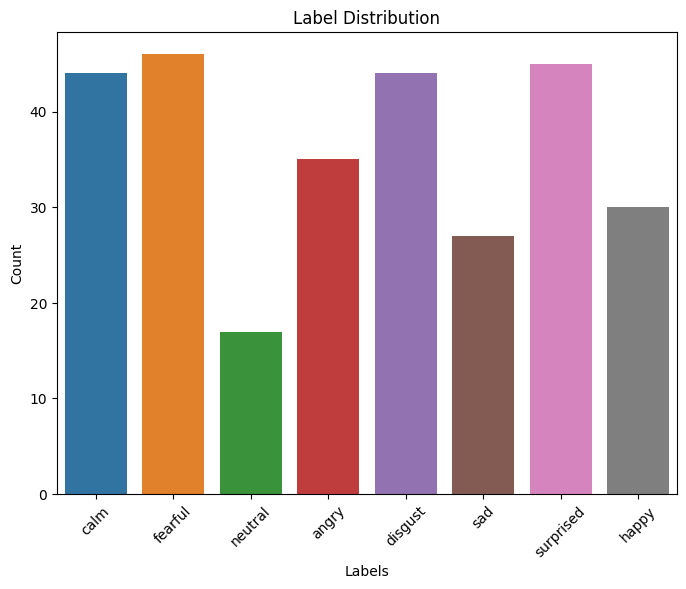




Gender Distribution:


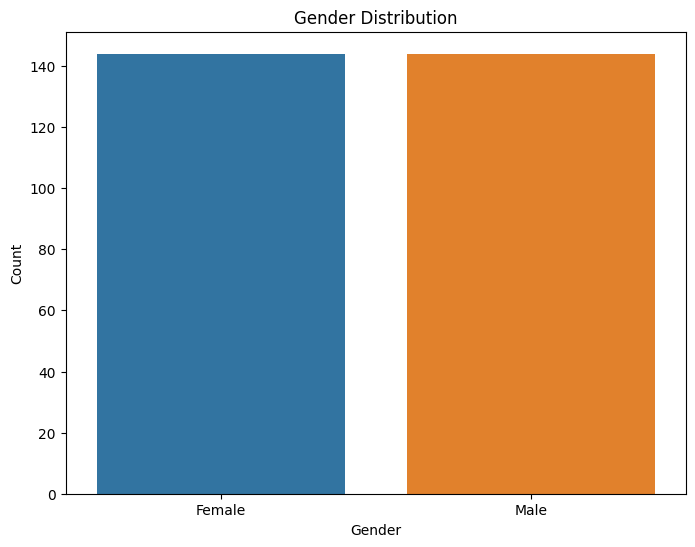




Actor Distribution:


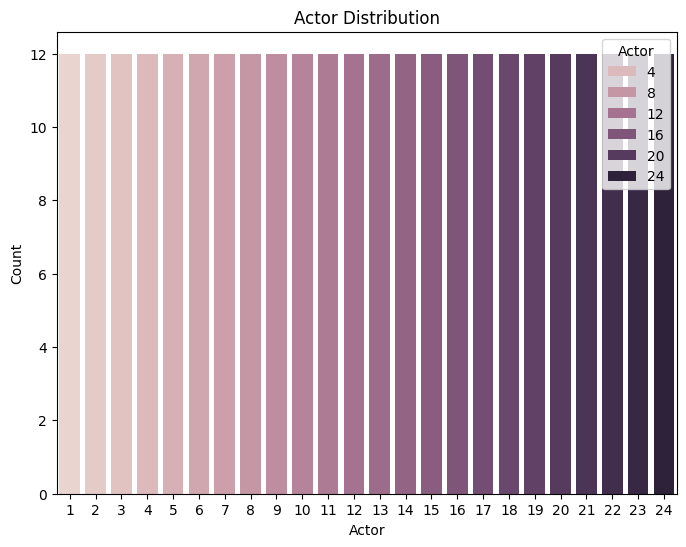




Audio Length Distribution:


<ipython-input-10-6a25bee4d540>:34: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  df['Audio_Length'] = df['Audio_Paths'].apply(lambda x: librosa.get_duration(filename=x))


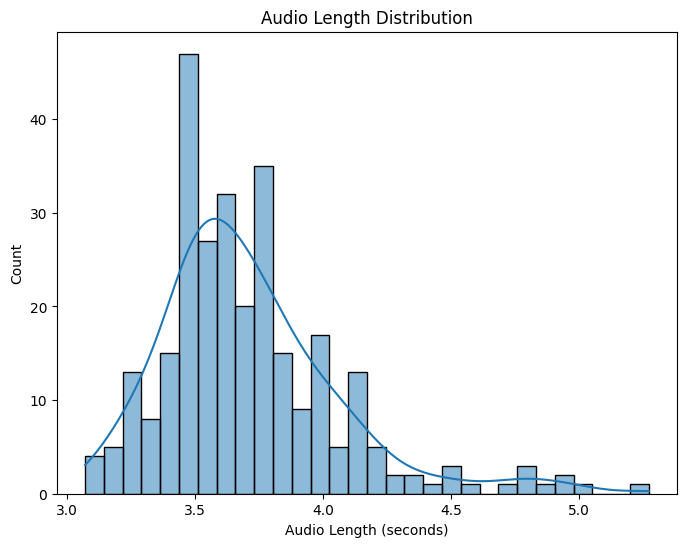




Label vs Gender Cross-Tabulation:


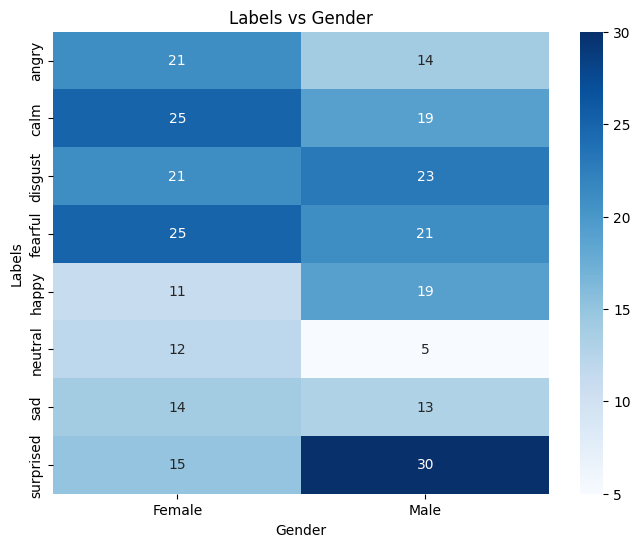




 Visualizing Sample Audio Spectrograms : 


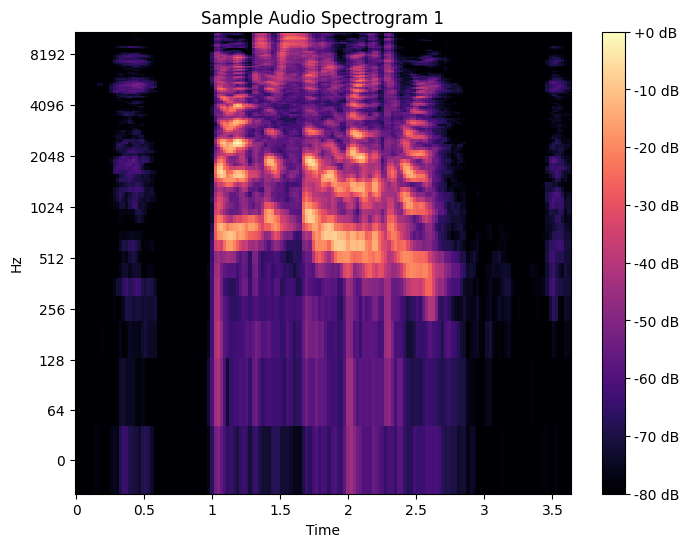

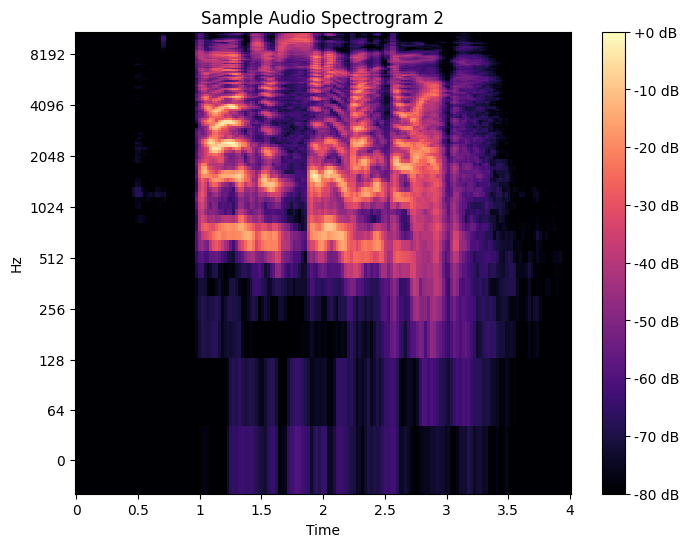

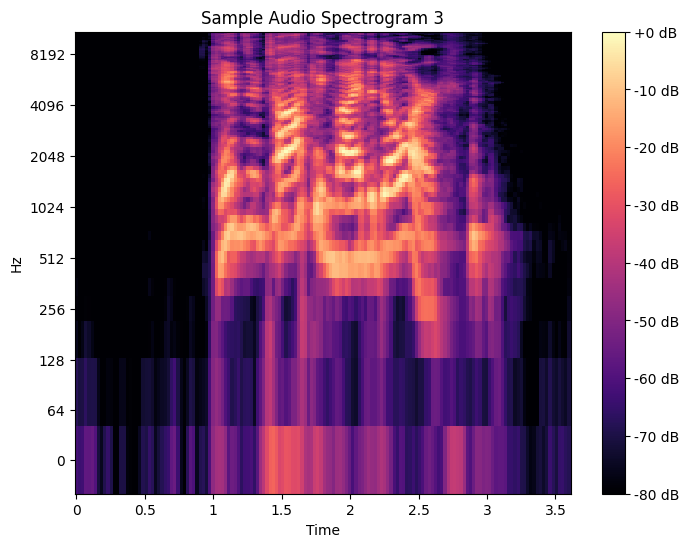

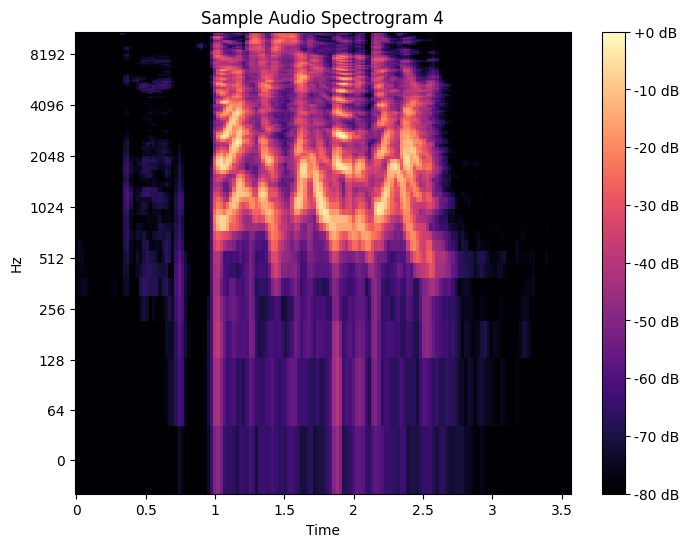

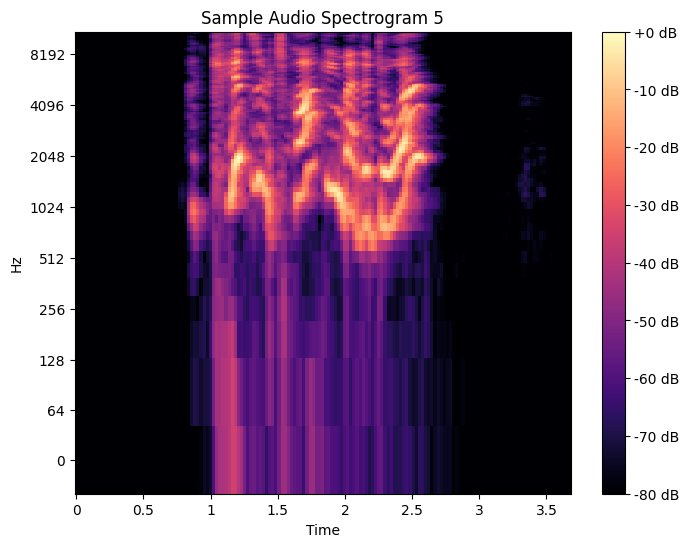






Visualizing Sample Audio Waveforms : 


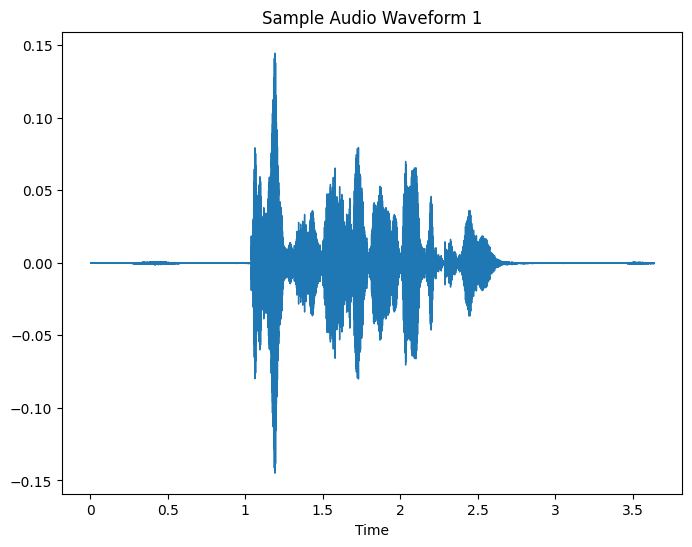

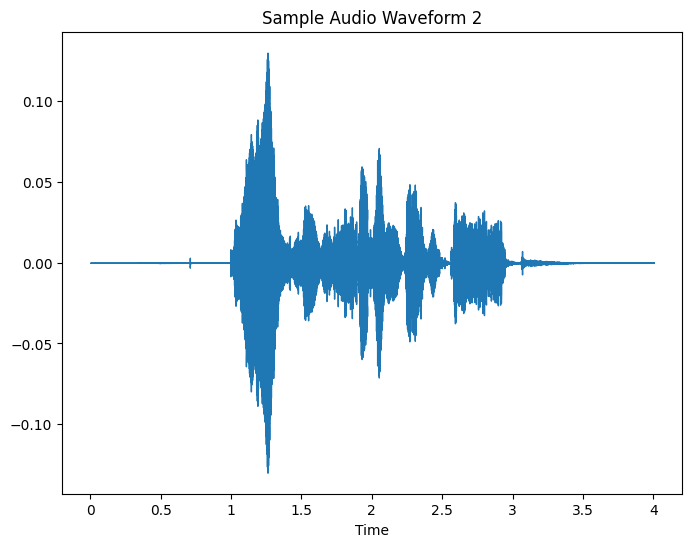

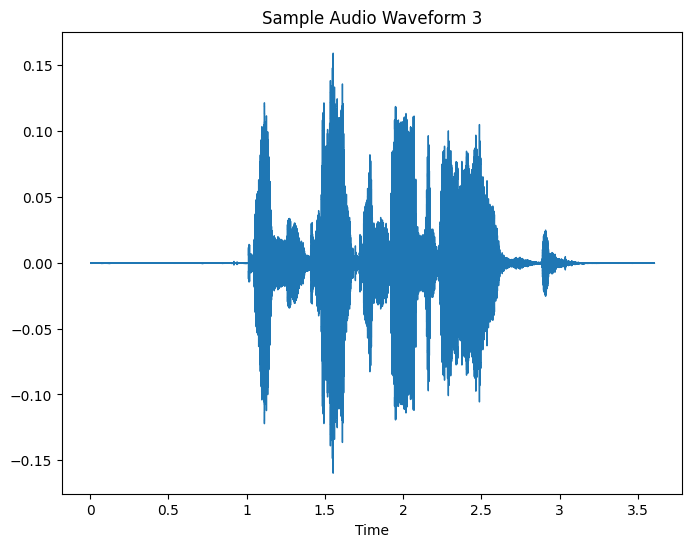

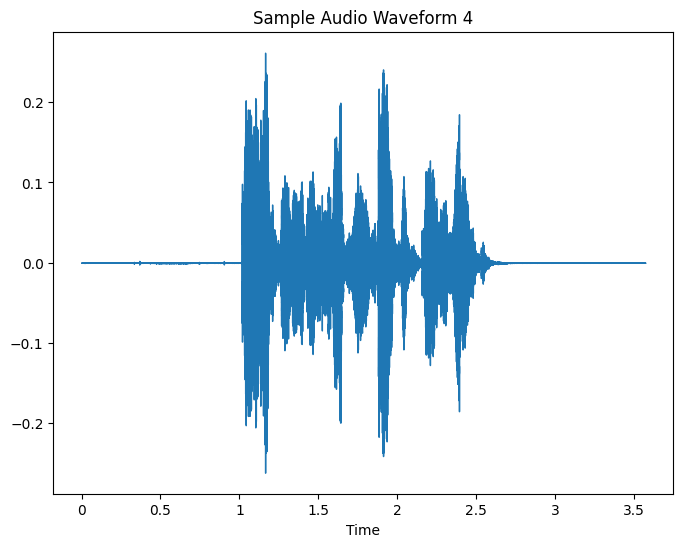

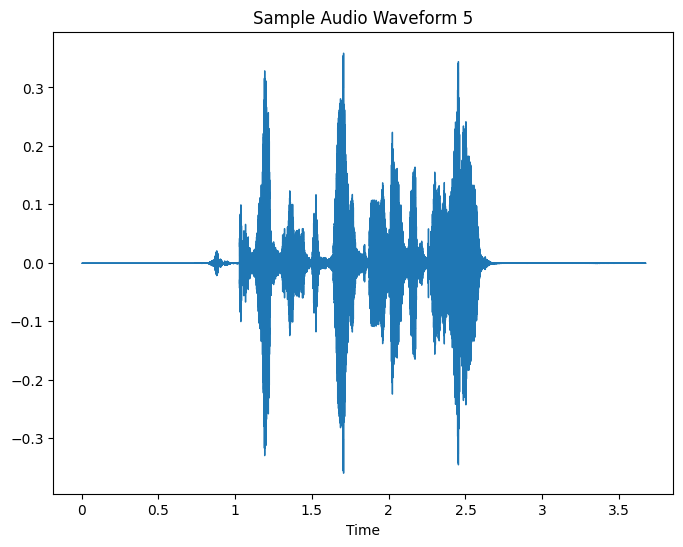






MFCC Visualization : 


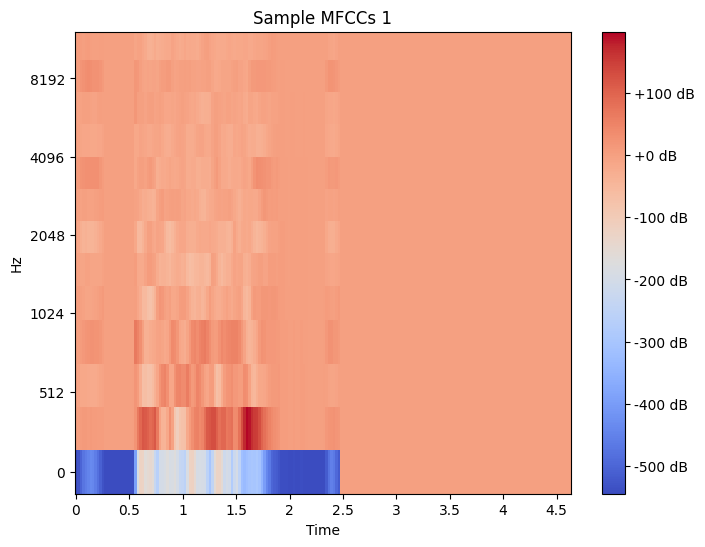

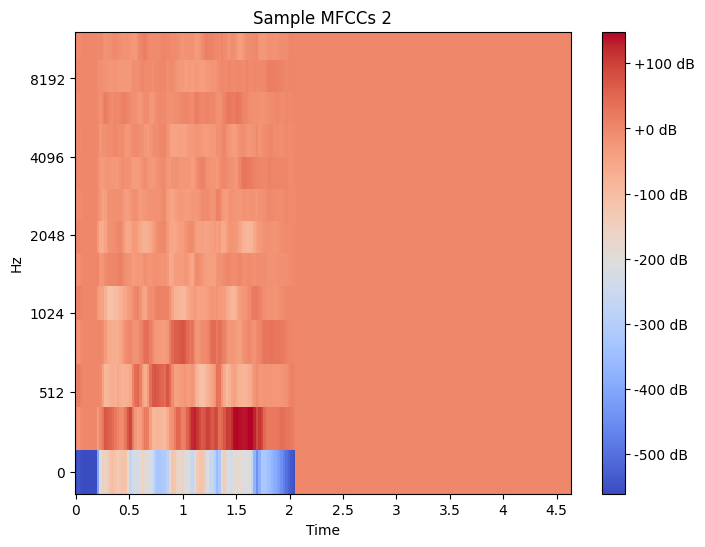

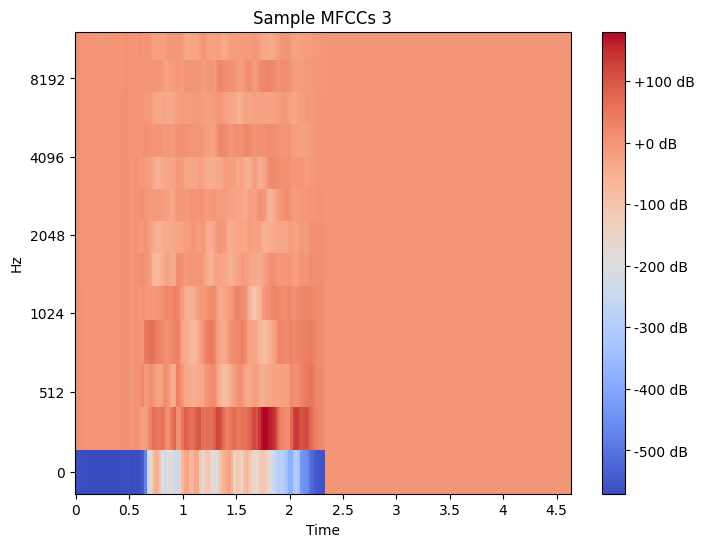

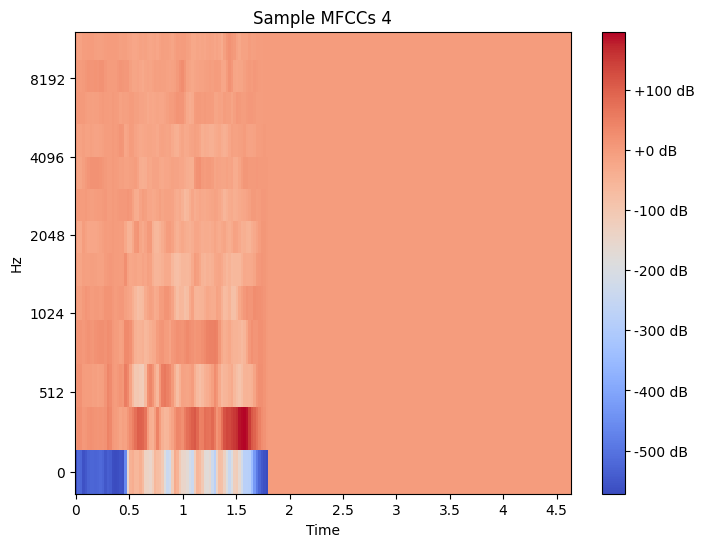

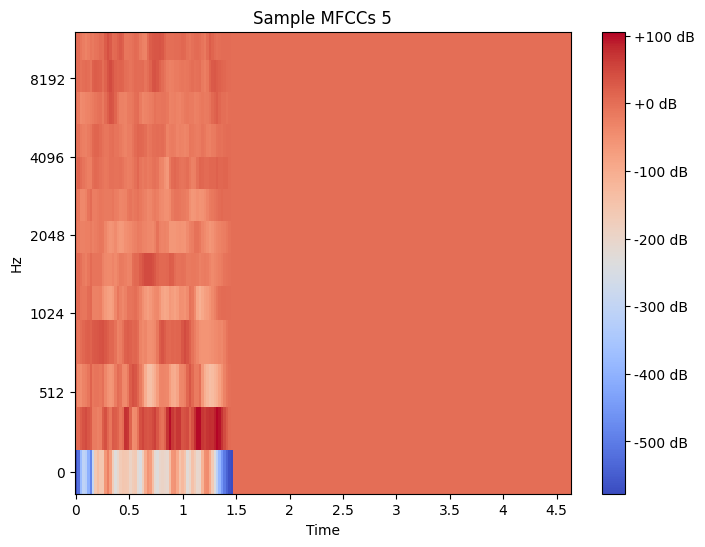

In [ ]:
Dataset_Audio = 'Processed_Ravdess/RAVDESS_Dataset.csv'
EDA_RAVDESS_Dataset(Dataset_Audio)

In [ ]:
Features_Ravdess = RAVDESS_Feature_Engeenring('Processed_Ravdess/RAVDESS_Dataset.csv' , 'Processed_Ravdess')

Processing Audio Files: 100%|██████████| 288/288 [00:06<00:00, 47.60it/s]

Features saved to Processed_Ravdess/RAVDESS_Dataset_Features.csv


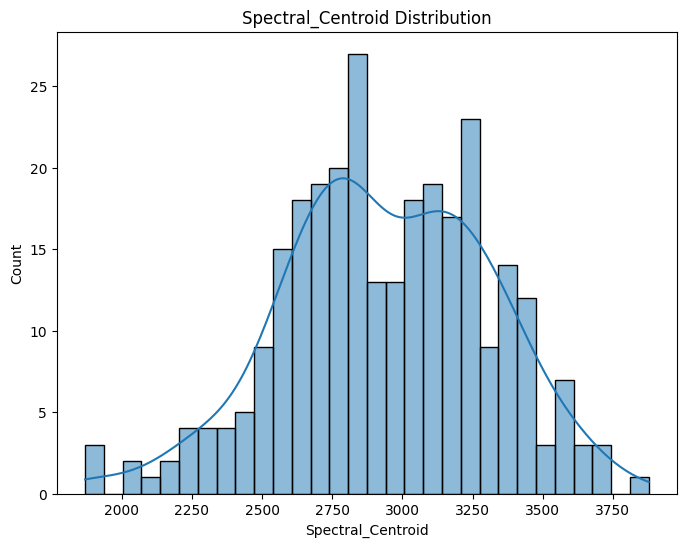




Spectral_Centroid by Emotion:


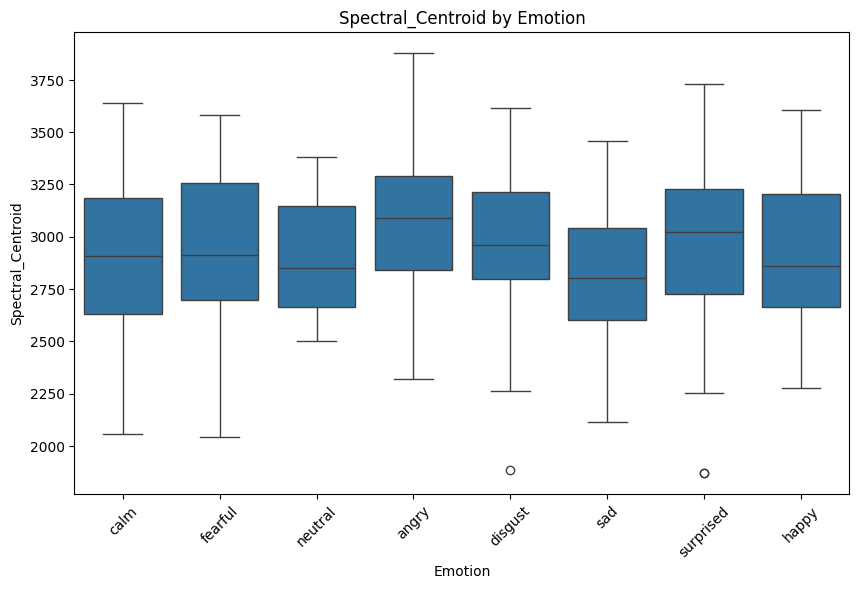




Spectral_Centroid by Gender:


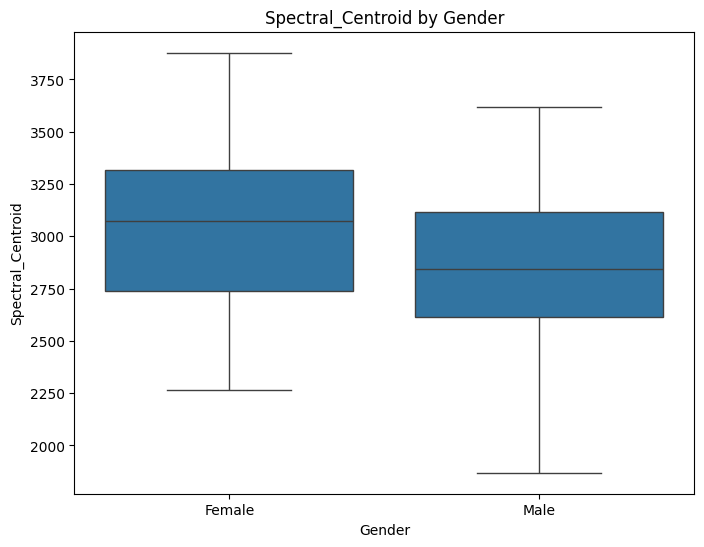

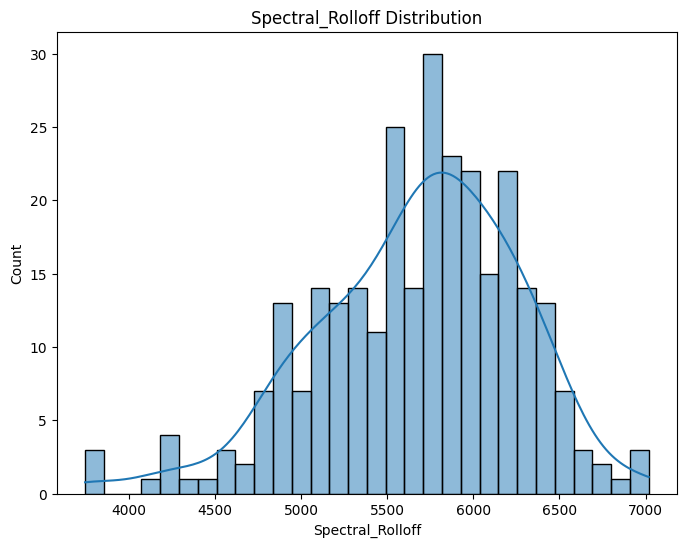




Spectral_Rolloff by Emotion:


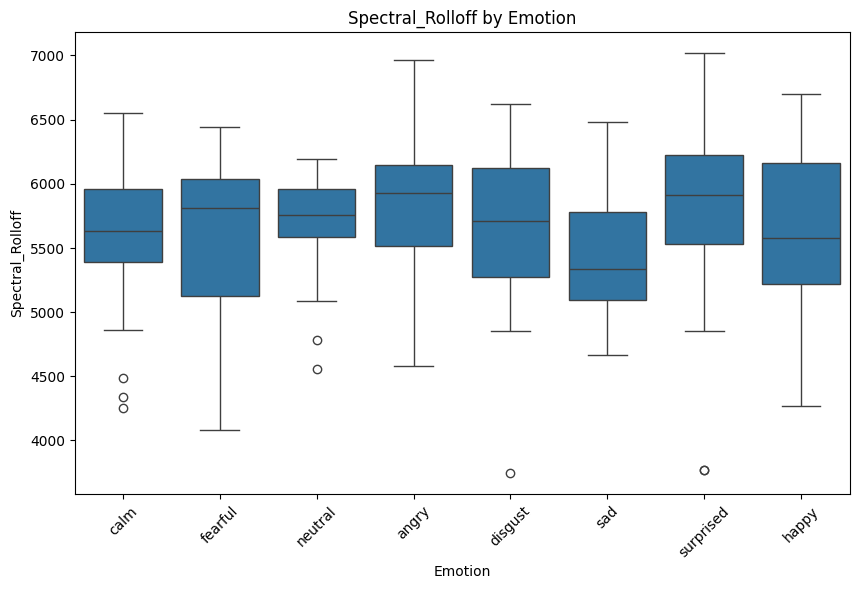




Spectral_Rolloff by Gender:


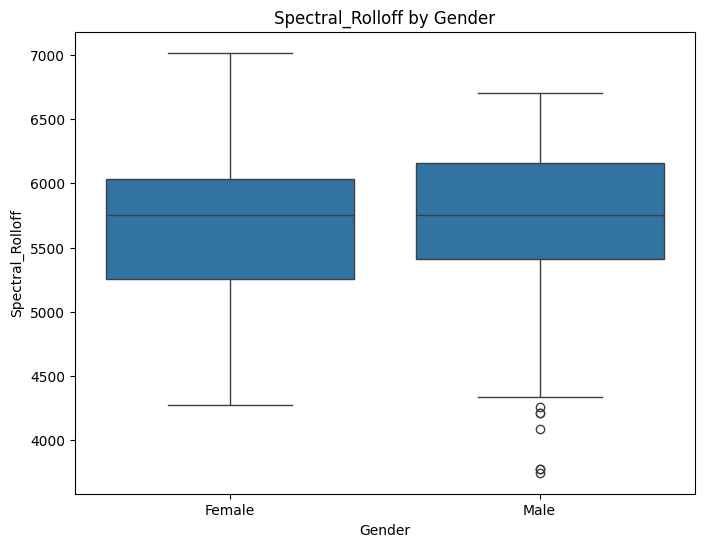

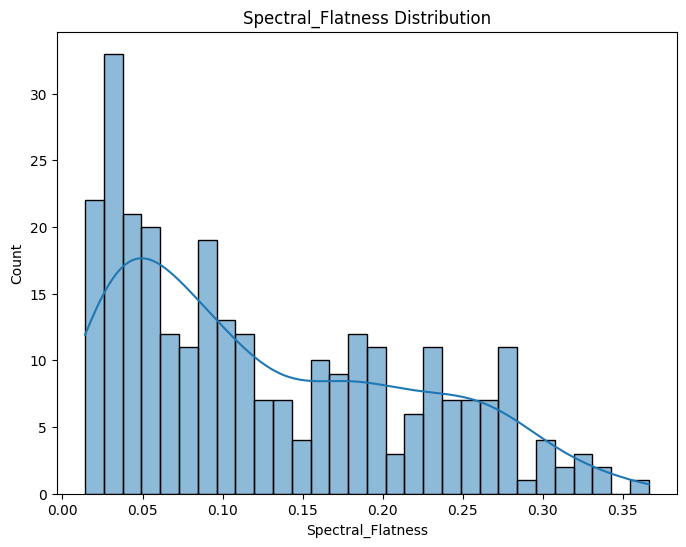




Spectral_Flatness by Emotion:


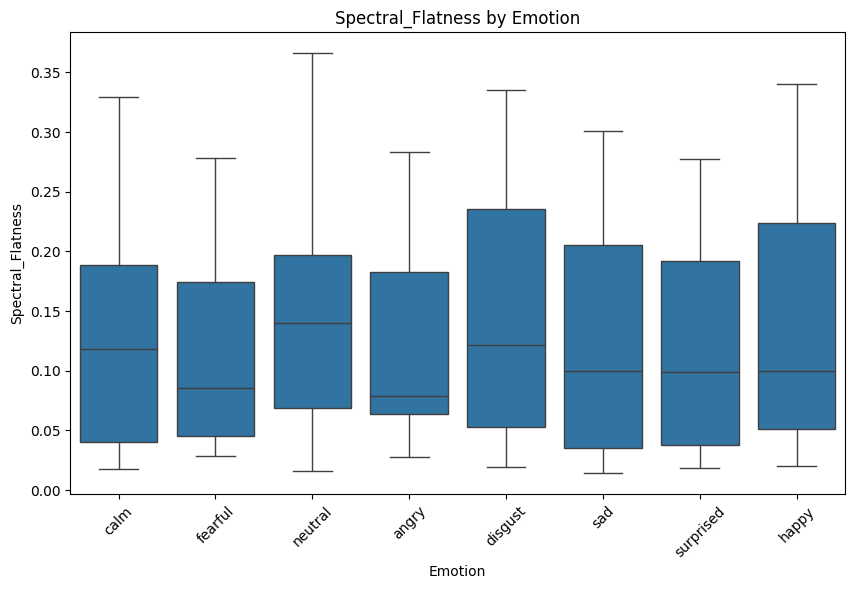




Spectral_Flatness by Gender:


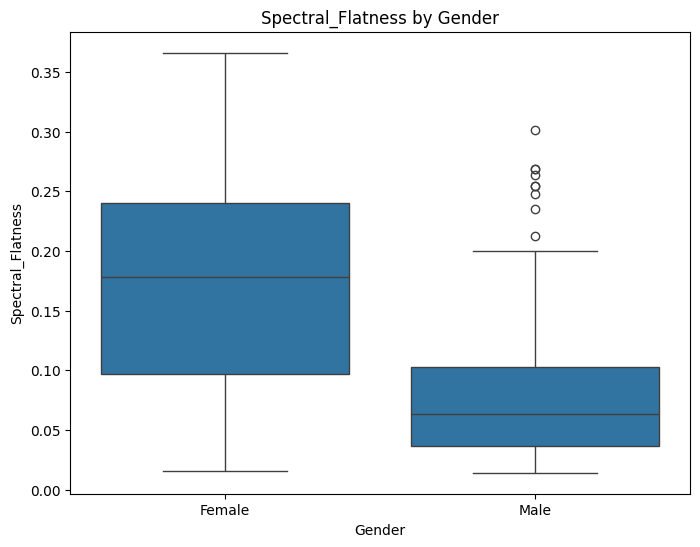

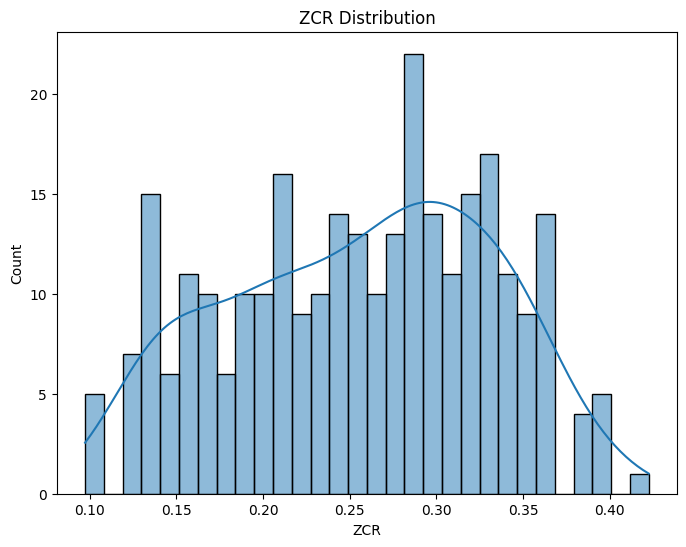




ZCR by Emotion:


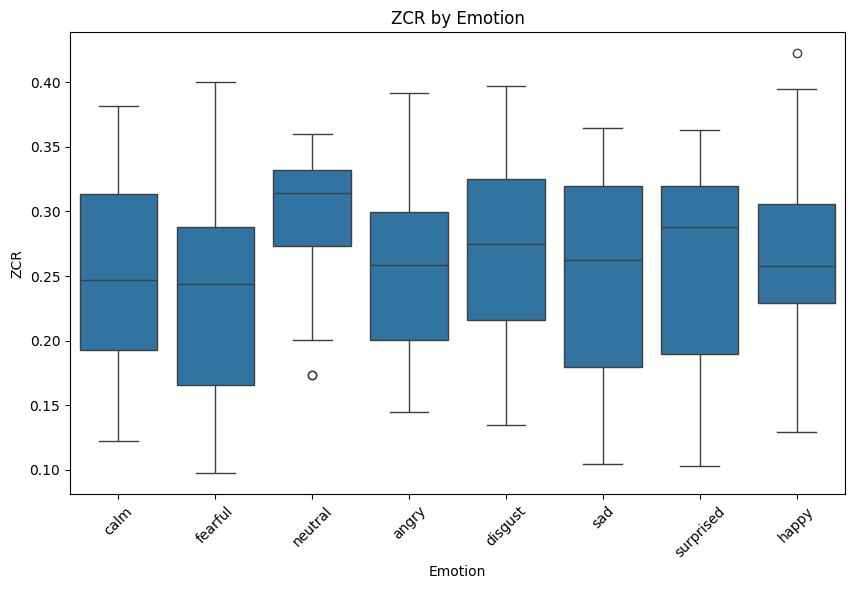




ZCR by Gender:


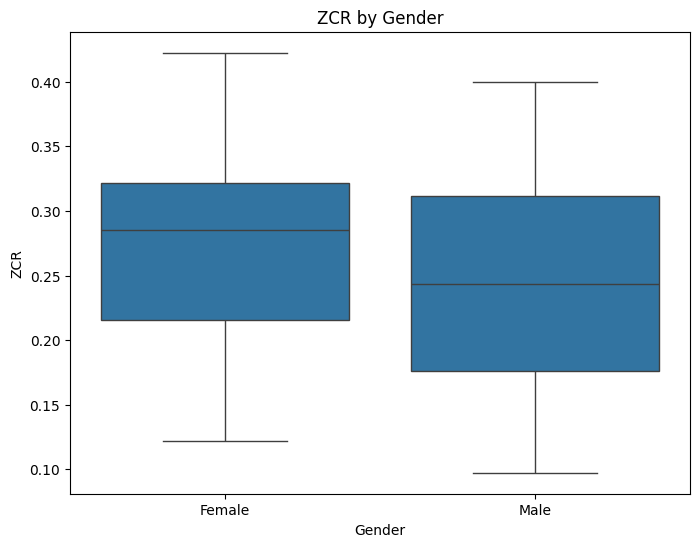




Correlation Heatmap of Features : 


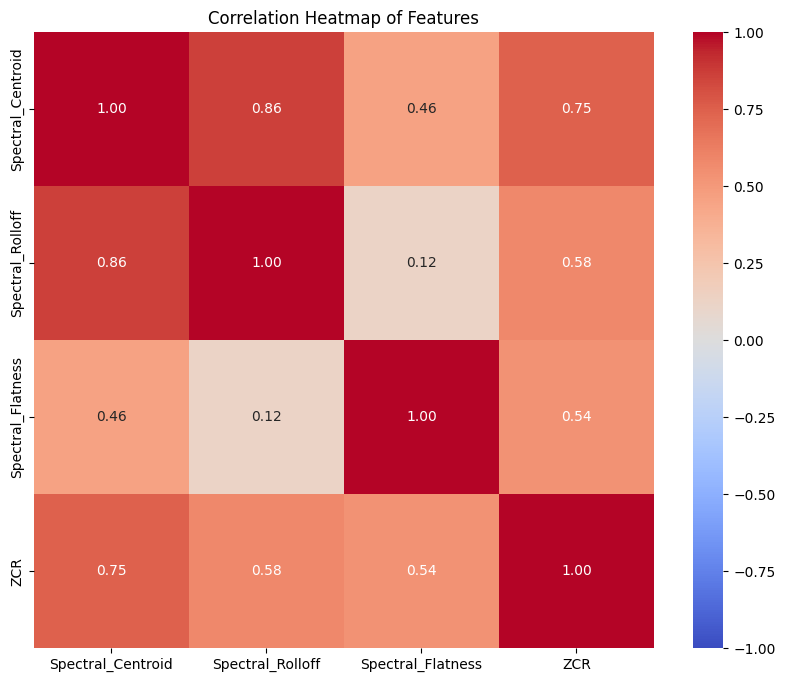

In [ ]:
Features_Ravdess_Dataset = 'Processed_Ravdess/RAVDESS_Dataset_Features.csv'
Plot_Features(Features_Ravdess_Dataset)

Feature : Spectral_Centroid


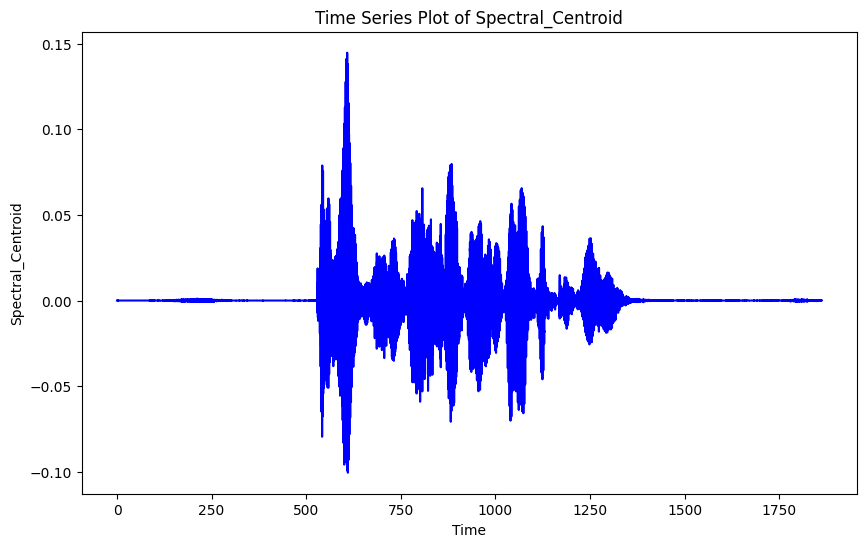



Feature : Spectral_Rolloff


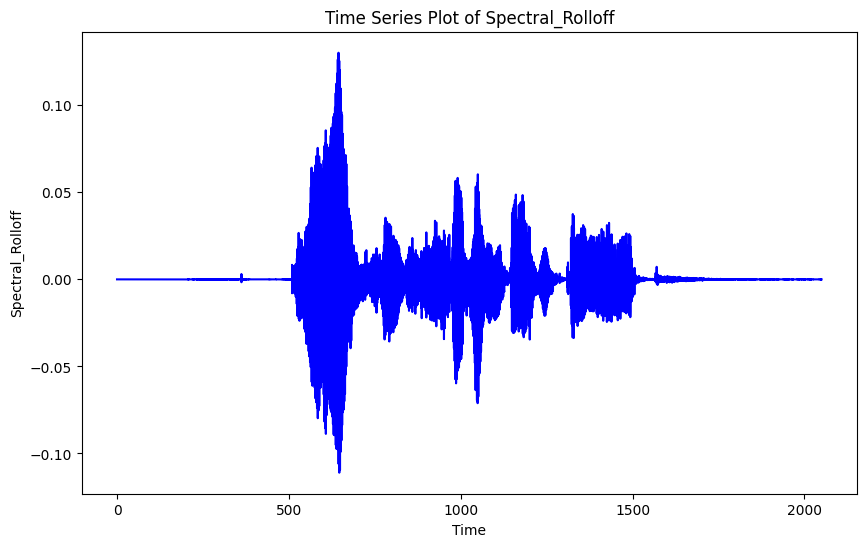



Feature : Spectral_Flatness


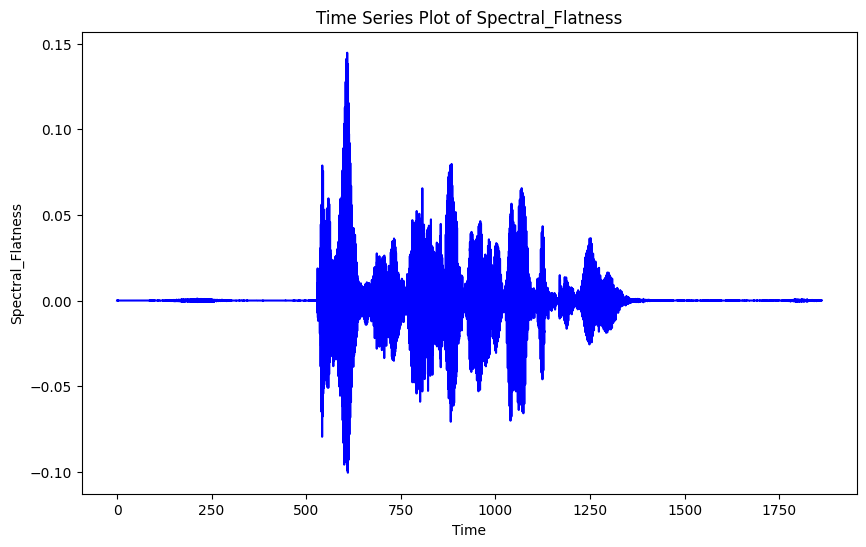



Feature : ZCR


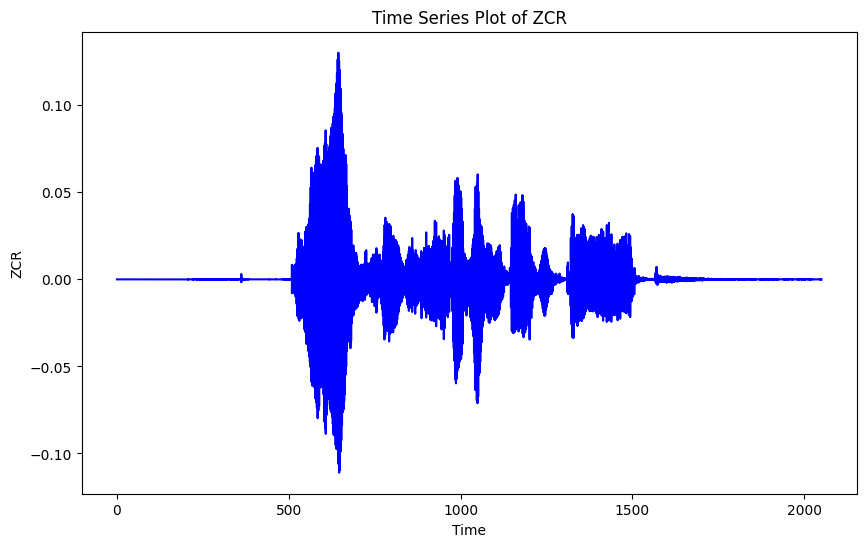

In [ ]:
Visualize_Features(Features_Ravdess_Dataset)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Bidirectional, Attention, Concatenate, Permute, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
import cv2
from tqdm import tqdm

In [ ]:
def load_preprocessed_data(image_csv_path, audio_csv_path, img_size=(128, 128), max_length=200, max_wav2vec_length=300, samples_per_emotion=100):

    df_images = pd.read_csv(image_csv_path)
    df_images = df_images[df_images['Is_Augmented'] == False]
    df_audio = pd.read_csv(audio_csv_path)

    common_emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    df_images = df_images[df_images['Emotions'].isin(common_emotions)]
    df_audio = df_audio[df_audio['Labels'].isin(common_emotions)]

    images = []
    mfccs = []
    wav2vec_features = []
    labels = []
    threat_levels = []

    for emotion in common_emotions:
        df_img_emotion = df_images[df_images['Emotions'] == emotion]
        df_img_sample = df_img_emotion.sample(n=min(samples_per_emotion, len(df_img_emotion)), random_state=42) if len(df_img_emotion) > 0 else pd.DataFrame()

        df_audio_emotion = df_audio[df_audio['Labels'] == emotion]
        df_audio_sample = df_audio_emotion.sample(n=min(samples_per_emotion, len(df_audio_emotion)), random_state=42) if len(df_audio_emotion) > 0 else pd.DataFrame()

        for _, row in df_img_sample.iterrows():
            img_path = row['Image_Paths']
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, img_size) / 255.0
            images.append(img)
            labels.append(row['Emotions'])
            threat_levels.append(row['Threat_Level'])

            if not df_audio_sample.empty:
                audio_row = df_audio_sample.iloc[0]
                mfcc = np.load(audio_row['Feature_Paths'])
                wav2vec = np.load(audio_row['Wav2Vec_Paths'])

                if mfcc.shape[1] > max_length:
                    mfcc = mfcc[:, :max_length]
                else:
                    mfcc = np.pad(mfcc, ((0, 0), (0, max_length - mfcc.shape[1])), mode='constant')

                if wav2vec.ndim == 3:
                    wav2vec = wav2vec.squeeze(axis=0)
                seq_len = wav2vec.shape[0]
                if seq_len > max_wav2vec_length:
                    wav2vec = wav2vec[:max_wav2vec_length, :]
                else:
                    wav2vec = np.pad(wav2vec, ((0, max_wav2vec_length - seq_len), (0, 0)), mode='constant')

                mfccs.append(mfcc)
                wav2vec_features.append(wav2vec)
            else:

                images.pop()
                labels.pop()
                threat_levels.pop()

        for _, row in df_audio_sample.iterrows():
            mfcc = np.load(row['Feature_Paths'])
            wav2vec = np.load(row['Wav2Vec_Paths'])

            if mfcc.shape[1] > max_length:
                mfcc = mfcc[:, :max_length]
            else:
                mfcc = np.pad(mfcc, ((0, 0), (0, max_length - mfcc.shape[1])), mode='constant')

            if wav2vec.ndim == 3:
                wav2vec = wav2vec.squeeze(axis=0)
            seq_len = wav2vec.shape[0]
            if seq_len > max_wav2vec_length:
                wav2vec = wav2vec[:max_wav2vec_length, :]
            else:
                wav2vec = np.pad(wav2vec, ((0, max_wav2vec_length - seq_len), (0, 0)), mode='constant')

            mfccs.append(mfcc)
            wav2vec_features.append(wav2vec)
            labels.append(row['Labels'])
            threat_levels.append(Map_To_Threat_Level(row['Labels']))

            if not df_img_sample.empty:
                img_row = df_img_sample.iloc[0]
                img = cv2.imread(img_row['Image_Paths'], cv2.IMREAD_GRAYSCALE)
                if img is None:
                    mfccs.pop()
                    wav2vec_features.pop()
                    labels.pop()
                    threat_levels.pop()
                    continue
                img = cv2.resize(img, img_size) / 255.0
                images.append(img)
            else:

                mfccs.pop()
                wav2vec_features.pop()
                labels.pop()
                threat_levels.pop()

    images = np.array(images)[..., np.newaxis]
    mfccs = np.array(mfccs)
    wav2vec_features = np.array(wav2vec_features)

    le_emotion = LabelEncoder()
    le_threat = LabelEncoder()
    labels = le_emotion.fit_transform(labels)
    threat_levels = le_threat.fit_transform(threat_levels)

    lengths = [len(images), len(mfccs), len(wav2vec_features), len(labels), len(threat_levels)]
    if len(set(lengths)) > 1:
        raise ValueError(f"Inconsistent sample counts: {lengths}")

    print(f"Loaded {len(images)} samples.")
    return images, mfccs, wav2vec_features, labels, threat_levels, le_emotion, le_threat

In [ ]:
def build_multimodal_model(img_size=(128, 128), n_mfcc=13, max_length=200, max_wav2vec_length=300, wav2vec_dim=768, num_emotions=7, num_threat_levels=2):

    # Facial branch (CNN)
    img_input = Input(shape=(img_size[0], img_size[1], 1), name='image_input')
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    img_features = Flatten()(x)
    img_features = Dense(256, activation='relu')(img_features)

    # Audio MFCC branch (BiLSTM)
    mfcc_input = Input(shape=(n_mfcc, max_length), name='mfcc_input')
    mfcc_reshaped = Permute((2, 1))(mfcc_input)
    mfcc_lstm = Bidirectional(LSTM(128, return_sequences=True))(mfcc_reshaped)
    mfcc_attention = Attention()([mfcc_lstm, mfcc_lstm])
    mfcc_features = Flatten()(mfcc_attention)
    mfcc_features = Dense(256, activation='relu')(mfcc_features)

    # Wav2Vec branch (BiLSTM)
    wav2vec_input = Input(shape=(max_wav2vec_length, wav2vec_dim), name='wav2vec_input')
    wav2vec_lstm = Bidirectional(LSTM(128, return_sequences=False))(wav2vec_input)  # Output: (batch, 256)
    wav2vec_features = Dense(256, activation='relu')(wav2vec_lstm)

    combined_features = Concatenate()([img_features, mfcc_features, wav2vec_features])
    combined_features = Dense(512, activation='relu')(combined_features)
    fusion_attention = Dense(512, activation='softmax')(combined_features)
    fused_features = Multiply()([combined_features, fusion_attention])

    emotion_output = Dense(num_emotions, activation='softmax', name='emotion_output')(fused_features)
    threat_output = Dense(num_threat_levels, activation='softmax', name='threat_output')(fused_features)

    model = Model(inputs=[img_input, mfcc_input, wav2vec_input], outputs=[emotion_output, threat_output])
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss={'emotion_output': 'sparse_categorical_crossentropy', 'threat_output': 'sparse_categorical_crossentropy'},
        metrics={'emotion_output': 'accuracy', 'threat_output': 'accuracy'}
    )

    return model

In [ ]:
def train_multimodal_model(model, images, mfccs, wav2vec_features, labels, threat_levels, batch_size=32, epochs=20, validation_split=0.2):

    history = model.fit(
        x={'image_input': images, 'mfcc_input': mfccs, 'wav2vec_input': wav2vec_features},
        y={'emotion_output': labels, 'threat_output': threat_levels},
        batch_size=batch_size,
        epochs=epochs,
        validation_split=validation_split,
        verbose=1
    )
    return history

In [ ]:
def evaluate_multimodal_model(model, images, mfccs, wav2vec_features, labels, threat_levels):

    metrics = model.evaluate(
        x={'image_input': images, 'mfcc_input': mfccs, 'wav2vec_input': wav2vec_features},
        y={'emotion_output': labels, 'threat_output': threat_levels},
        verbose=0
    )
    return {
        'emotion_loss': metrics[0],
        'threat_loss': metrics[1],
        'emotion_accuracy': metrics[2],
        'threat_accuracy': metrics[3]
    }

In [ ]:
image_csv_path = 'Images_Dataset.csv'
audio_csv_path = 'Processed_Ravdess/RAVDESS_Dataset.csv'

img_size = (128, 128)
n_mfcc = 13
max_length = 200
wav2vec_dim = 768
num_emotions = 7
num_threat_levels = 2

In [ ]:
print("Loading preprocessed data")
images, mfccs, wav2vec_features, labels, threat_levels, le_emotion, le_threat = load_preprocessed_data(
    image_csv_path=image_csv_path,
    audio_csv_path=audio_csv_path,
    img_size=img_size,
    max_length=max_length
)


Loading preprocessed data
Loaded 581 samples.


In [ ]:
print("Splitting data into train and test sets")
(
    images_train, images_test,
    mfccs_train, mfccs_test,
    wav2vec_train, wav2vec_test,
    labels_train, labels_test,
    threat_train, threat_test
) = train_test_split(
    images, mfccs, wav2vec_features, labels, threat_levels,
    test_size=0.2, random_state=42
)

Splitting data into train and test sets


In [ ]:
print("Building multimodal model")
model = build_multimodal_model(
    img_size=img_size,
    n_mfcc=n_mfcc,
    max_length=max_length,
    wav2vec_dim=wav2vec_dim,
    num_emotions=num_emotions,
    num_threat_levels=num_threat_levels
)
model.summary()

Building multimodal model


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        320 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mfcc_input          │ (None, 13, 200)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 200, 13)   │          0 │ mfcc_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 200, 256)  │    145,408 │ permute[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 200, 256)  │          0 │ bidirectional[0]… │
│ (Attention)         │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ wav2vec_input       │ (None, 300, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32768)     │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 51200)     │          0 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 256)       │    918,528 │ wav2vec_input[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  8,388,864 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │ 13,107,456 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     65,792 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 768)       │          0 │ dense[0][0],    

 Total params: 23,379,721 (89.19 MB)

 Trainable params: 23,379,721 (89.19 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("Training model")
history = train_multimodal_model(
    model=model,
    images=images_train,
    mfccs=mfccs_train,
    wav2vec_features=wav2vec_train,
    labels=labels_train,
    threat_levels=threat_train,
    batch_size=32,
    epochs= 50 ,
    validation_split=0.2
)

Training model
Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 212ms/step - emotion_output_accuracy: 0.2244 - emotion_output_loss: 1.8470 - loss: 2.4804 - threat_output_accuracy: 0.5547 - threat_output_loss: 0.6320 - val_emotion_output_accuracy: 0.1935 - val_emotion_output_loss: 1.6863 - val_loss: 2.0575 - val_threat_output_accuracy: 0.6344 - val_threat_output_loss: 0.3715
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - emotion_output_accuracy: 0.2574 - emotion_output_loss: 1.5580 - loss: 1.8998 - threat_output_accuracy: 0.7708 - threat_output_loss: 0.3410 - val_emotion_output_accuracy: 0.1935 - val_emotion_output_loss: 1.5680 - val_loss: 1.9051 - val_threat_output_accuracy: 0.9140 - val_threat_output_loss: 0.3372
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - emotion_output_accuracy: 0.2253 - emotion_output_loss: 1.4895 - loss: 1.8064 - threat_output_accuracy: 0.9201 - threat_output_loss: 0.3168 - val_emotion_output_accuracy: 0.2151 - val_emotion_output_loss: 1.4739 - val_loss:

In [ ]:
print("Evaluating model")
metrics = evaluate_multimodal_model(
    model=model,
    images=images_test,
    mfccs=mfccs_test,
    wav2vec_features=wav2vec_test,
    labels=labels_test,
    threat_levels=threat_test
)

print("Evaluation Metrics:")
print(f"Emotion Loss: {metrics['emotion_loss']:.4f}")
print(f"Threat Loss: {metrics['threat_loss']:.4f}")
print(f"Emotion Accuracy: {metrics['emotion_accuracy']:.4f}")
print(f"Threat Accuracy: {metrics['threat_accuracy']:.4f}")

Evaluating model
Evaluation Metrics:
Emotion Loss: 1.1957
Threat Loss: 0.9997
Emotion Accuracy: 0.1802
Threat Accuracy: 0.6239


In [ ]:
#!pip install scikit-image==0.19.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 58.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 84.5 MB/s eta 0:00:00


In [ ]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries

In [ ]:
def grad_cam(model, img, mfcc, wav2vec, layer_name='conv2d_last', output_name='emotion_output', class_idx=None):

    img = np.expand_dims(img, axis=0)
    mfcc = np.expand_dims(mfcc, axis=0)
    wav2vec = np.expand_dims(wav2vec, axis=0)

    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.get_layer(output_name).output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model([img, mfcc, wav2vec])
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_mean(conv_outputs * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / (np.max(heatmap) + 1e-10)

    return heatmap

In [ ]:
def visualize_grad_cam(img, heatmap, title):

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    img_uint8 = np.uint8(255 * img[..., 0])
    superimposed_img = heatmap * 0.4 + cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR) * 0.6
    plt.figure(figsize=(8, 8))
    plt.imshow(superimposed_img.astype('uint8'))
    plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:
def feature_importance_perturbation(model, audio_features, img, mfcc, wav2vec, input_name='mfcc_input', output_name='emotion_output', num_perturbations=100):

    img = np.expand_dims(img, axis=0)
    mfcc = np.expand_dims(mfcc, axis=0)
    wav2vec = np.expand_dims(wav2vec, axis=0)

    baseline_prediction = model.predict([img, mfcc, wav2vec], verbose=0)[model.output_names.index(output_name)]

    num_perturbations = min(num_perturbations, audio_features.shape[-1] if input_name == 'wav2vec_input' else audio_features.shape[0])  # Adjust for MFCC shape

    importance_scores = []
    for i in range(num_perturbations):
        perturbed_features = audio_features.copy()

        if input_name == 'mfcc_input':
            perturbed_features[i, :] = 0
        else:
            perturbed_features[i] = 0

        if input_name == 'mfcc_input':
            perturbed_features = perturbed_features[np.newaxis, ...]
        else:
            perturbed_features = perturbed_features[np.newaxis, ...]

        perturbed_prediction = model.predict(
            [img, mfcc if input_name == 'wav2vec_input' else perturbed_features, wav2vec if input_name == 'mfcc_input' else perturbed_features],  # Adjust input order
            verbose=0
        )[model.output_names.index(output_name)]

        importance = np.mean(np.abs(baseline_prediction - perturbed_prediction))
        importance_scores.append(importance)

    return np.array(importance_scores)

In [ ]:
def visualize_feature_importance(importance_scores, title, feature_dim, feature_type='MFCC Coefficient'):

    plt.figure(figsize=(12, 4))
    plt.bar(np.arange(feature_dim), importance_scores, color='r')
    plt.title(title)
    plt.xlabel(feature_type)
    plt.ylabel('Importance')
    plt.grid(True)
    plt.show()

In [ ]:
def Apply_LIME(Model, Image, Num_Samples=1000):

    print("Generating LIME explanation.")
    print("\n")
    Explainer = lime_image.LimeImageExplainer()
    def Predict_Fn(Images):
        Images = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in Images])
        Images = Images[..., np.newaxis]
        Dummy_Audio = np.zeros((len(Images), 13, 200))
        Dummy_Wav = np.zeros((len(Images), 300, 768))
        predictions = Model.predict([Images, Dummy_Audio, Dummy_Wav])[0]
        return predictions

    Image_RGB = cv2.cvtColor(Image[0].astype(np.uint8), cv2.COLOR_GRAY2RGB)
    Explanation = Explainer.explain_instance(
        Image_RGB,
        Predict_Fn,
        top_labels=5,
        num_samples=Num_Samples
    )
    Temp, Mask = Explanation.get_image_and_mask(
        Explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=True
    )
    Marked = mark_boundaries(Temp / Temp.max(), Mask)
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(Image[0])
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(Marked)
    plt.title('LIME Explanation')
    plt.tight_layout()
    plt.show()
    print("LIME explanation completed.")
    print("\n")
    return Marked

In [ ]:
def Visualize_Wav2Vec_Features(Wav2Vec_Features, Label):

    print("Generating Wav2Vec feature importance.")
    print("\n")
    Mean_Features = np.mean(Wav2Vec_Features, axis=1)
    plt.figure(figsize=(12, 4))
    plt.plot(Mean_Features)
    plt.title(f'Wav2Vec Feature Importance for {Label}')
    plt.xlabel('Feature Dimension')
    plt.ylabel('Mean Activation')
    plt.show()
    print("Wav2Vec feature visualization completed.")
    print("\n")

In [ ]:
sample_idx = 65
test_img = images_test[sample_idx]
test_mfcc = mfccs_test[sample_idx]
test_wav2vec = wav2vec_test[sample_idx]

Generating Grad-CAM explanation


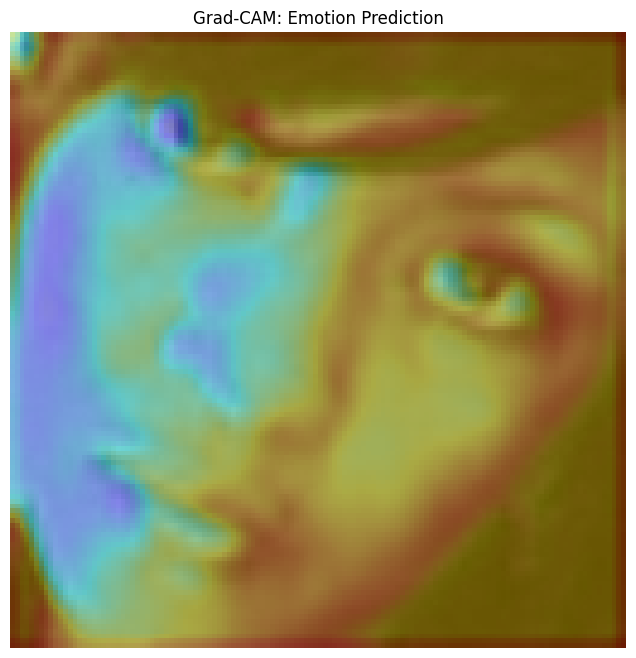

In [ ]:
print("Generating Grad-CAM explanation")
heatmap = grad_cam(
    model, test_img, test_mfcc, test_wav2vec,
    layer_name='conv2d_1', output_name='emotion_output'
)
visualize_grad_cam(test_img, heatmap, "Grad-CAM: Emotion Prediction")

Applying LIME.
Generating LIME explanation.




  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━

<ipython-input-73-9a32f22feeb0>:27: RuntimeWarning: invalid value encountered in divide
  Marked = mark_boundaries(Temp / Temp.max(), Mask)


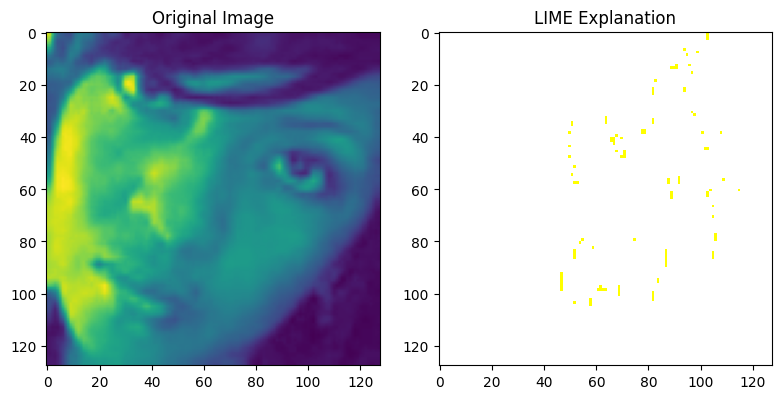

LIME explanation completed.


LIME application completed.



In [ ]:
print("Applying LIME.")
Marked = Apply_LIME(model, [test_img], Num_Samples=500)
print("LIME application completed.\n")

Generating MFCC feature importance


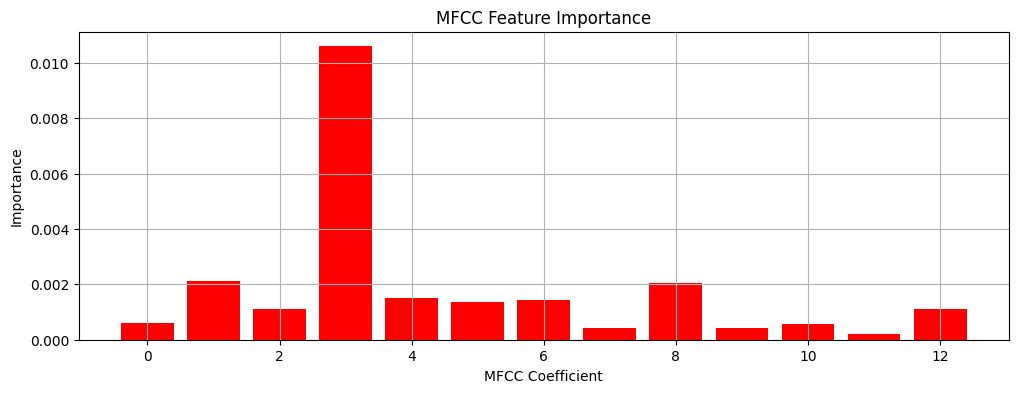

Generating Wav2Vec feature importance


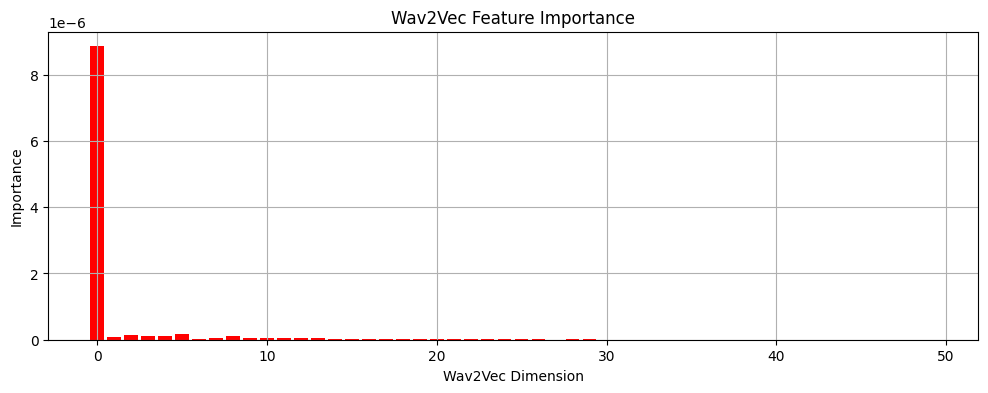

In [ ]:
print("Generating MFCC feature importance")
mfcc_importance = feature_importance_perturbation(
model, test_mfcc, test_img, test_mfcc, test_wav2vec,
input_name='mfcc_input', output_name='emotion_output', num_perturbations=n_mfcc
)
visualize_feature_importance(mfcc_importance, "MFCC Feature Importance", n_mfcc, "MFCC Coefficient")

print("Generating Wav2Vec feature importance")
wav2vec_importance = feature_importance_perturbation(
model, test_wav2vec, test_img, test_mfcc, test_wav2vec,
input_name='wav2vec_input', output_name='emotion_output', num_perturbations=50
)
visualize_feature_importance(wav2vec_importance, "Wav2Vec Feature Importance", 50, "Wav2Vec Dimension")

In [ ]:
Trained_Model = build_multimodal_model()
df_Face = pd.read_csv('Images_Dataset.csv')
df_Audio = pd.read_csv('Processed_Ravdess/RAVDESS_Dataset.csv')
Label_Encoder = LabelEncoder().fit(df_Audio['Labels'].unique())

In [ ]:
Sample_Idx = 0
Sample_Image = np.expand_dims(cv2.resize(cv2.cvtColor(cv2.imread(df_Face['Image_Paths'].iloc[Sample_Idx]), cv2.COLOR_BGR2RGB), (128, 128)) / 255.0, axis=0)
Sample_Audio = np.expand_dims(np.load(df_Audio['Feature_Paths'].iloc[Sample_Idx]), axis=0)
Sample_Wav2Vec = np.expand_dims(np.load(df_Audio['Wav2Vec_Paths'].iloc[Sample_Idx]), axis=0)
Sample_Label = df_Audio['Labels'].iloc[Sample_Idx]
Sample_Class_Idx = Label_Encoder.transform([Sample_Label])[0]

Visualizing Wav2Vec features.
Generating Wav2Vec feature importance.




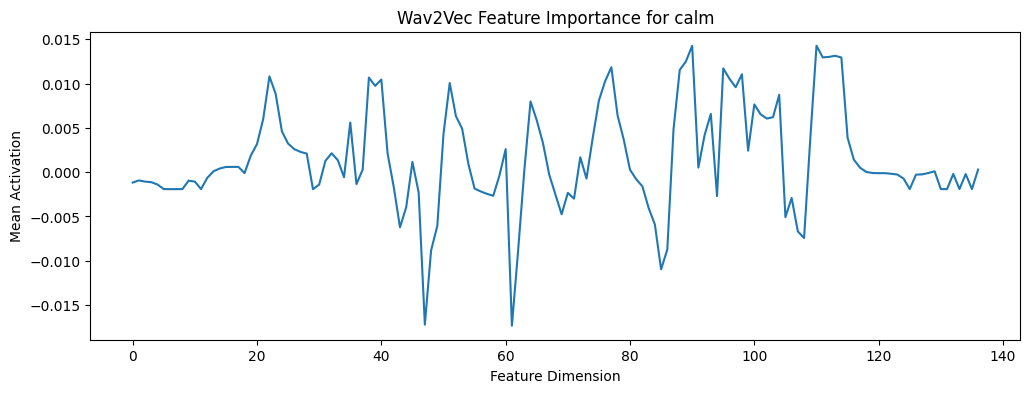

Wav2Vec feature visualization completed.




In [ ]:
print("Visualizing Wav2Vec features.")
Visualize_Wav2Vec_Features(Sample_Wav2Vec[0], Sample_Label)